<!--

# Deliverable 1

A Jupyter notebook showing a supervised learning problem description, EDA procedure, analysis (model building and training), result, and discussion/conclusion.

Suppose your work becomes so large that it doesn’t fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead.

If your project doesn't fit into Jupyter notebook format (E.g. you built an app that uses ML), write your approach as a report and submit it in a pdf form.

-->

# Introduction

## Project Topic

This project utilizes unsupervised and supervised machine learning (ML) algorithms to perform price
prediction on real-world real estate listings downloaded from [Zillow.com][zillow] and with
additional listing information scraped from [Redfin.com][redfin].  To start @sec-data describes the
source of the data and introduces the dataset. @sec-clean uses common techniques to clean the
dataset, removing outliers, and sanitizing columns, building a dataset that can be input into varied
ML algorithms. @sec-eda explores the dataset and produces visualizations for the author and audience
to gain an initial understanding of the data. This section also explores the interactions between
features and begins to analyze collinearity.

In @sec-model we dive deep into both unsupervised and supervised ML algorithms and build models to
cluster, then regress, on the data, aiming to create subsets of data that more accurately model
price than one large dataset. @sec-results discusses the results of the modeling and aims to select
a best path for price prediction. Finally @sec-conclusion details the outcomes of this project and
discusses areas of further research. All files and code for this project can be found here:
<https://github.com/simmsa/dtsa_5510_final>.

To narrow down the listings, provide simpler data collection, and make the result more relevant for
the author, this document focuses on real estate listings in the Denver Colorado metropolitan area.
As this project utilizes a relatively small amount of real world data, the outcomes may not be
definitive. Through this project we will aim to highlight the shortcomings of this analysis and
discuss methods for improvement of data size and data quality. As we build our models we are aiming
to find a good balance of accuracy and execution speed. We want to be careful of creating a model
that is simple for this use case, but too complex for a larger problem.

## Project Goal

The goal of this project is to build pricing model to predict real estate listing prices on new real
estate listings to seek out listings that may be undervalued. To achieve this goal we plan to use a
ML divide and conquer strategy, which uses clustering and principal component techniques to reduce
the data into smaller groups. These smaller groups will be passed into many supervised regression
algorithms and the accuracy will be combined to determine the best performing combination of models.

For this dataset, our target variable is price, a floating-point value. To model this variable
regression algorithms are a suitable choice. It is worth noting that typical regression algorithms
are compatible with floating-point features. We plan to convert as much of the data as possible to
floating point values. As this aspect is not the primary focus of this project, certain features may
be omitted to streamline the construction and analysis of the models. Given this, we strive to keep
the core values of the data. And our goal for cleaning and processing the data is to build a unified
source of truth that will be utilized by all ML models.

## Project Plan

In @fig-simple we outline the steps necessary to reach our goal of predicting the price of a real
estate listing.


```{mermaid}
%%| label: fig-simple
%%| fig-cap: Unsupervised Real Estate Price Prediction Flowchart

flowchart TD
    A("Data Cleaning / Wrangling")
    B("Imputation")
    C("Feature Selection")
    subgraph unsupervised ["Unsupervised ML"]
        subgraph clustering ["Clustering"]
            D("KMeans")
            E("AgglomerativeClustering")
        end
        subgraph dimred ["Dimensionality Reduction"]
            L("Principal Component Analysis")
        end
    end

    subgraph supervised ["Supervised Regression"]
        F("Linear Regression")
        G(AdaBoostRegressor)
        H(XGBRegressor)
    end

    J["Analysis"]

    K["Selection"]


    A --> B --> C

    C --> unsupervised --> supervised --> J --> K
```


# Python Setup {#sec-code-setup}

The following code section includes the python libraries used to execute the code contained in this
document. See @sec-code-env for complete details on the environment and libraries used to execute
the code in this document.


In [1]:
import itertools
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import xgboost as xgb

sns.set_theme()

2023-06-26 19:56:03.238826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualization Functions


In [2]:
def brand_plot(has_subplots=False):
    if has_subplots == False:
        plt.suptitle("Real Estate Listing Price Prediction")

    txt = "DTSA 5510 - 2023 Summer 1 - Andrew Simms"
    plt.figtext(
        0.95,
        -0.01,
        txt,
        wrap=True,
        horizontalalignment="right",
        fontsize=6,
        fontstyle="italic",
    )
    plt.tight_layout()

# Data Information {#sec-data}

## Data Source

In the United States (US) real estate listing data is typically not readily available to the
consumer. Typically the [Multiple Listing Service (MLS)][MLS] contains these listings and which they
make available to realtors. To provide a product, companies like [Zillow][Zillow] and
[Redfin][Redfin] acquire these listings and provide a service that makes it easy for users to find
real estate properties for sale. Ideally, to source real estate listing data, we would use [MLS],
but they do not offer a readily available API. But we can use data from Zillow and Redfin, we just
have to find methods for scraping each respective site.

Data is acquired from [Zillow][Zillow] using our custom made [`scraper.py`][scraper.py] python script.  This script
interfaces with the [Zillow][zillow] `GetSearchPageState` API and downloads current real estate
listings by zip code for the [included zip codes][zip_codes.json]. A framework for this type of
scraping can be found in [this Zillow web scraping tutorial][scrapfly]. This `json` is then
formatted with [`formatter.py`][formatter.py] and saved to a `csv` file.

To add additional features we use the addresses from Zillow and query additional data from
[Redfin][Redfin] using the [Python-Redfin](https://github.com/reteps/redfinref) library. Querying
Redfin adds additional information about school districts, home features, neighborhood, and listing
condition that should be able add additional features that improve the pricing model. This data is
combined with the Zillow data and save into a `csv` file.

### Data Acquisition Flowchart

:::{.column-page}


```{mermaid}
%%| label: fig-daq
%%| fig-cap: Data Acquisition Flowchart

flowchart LR
    subgraph daq ["Data Acquisition"]
        direction LR
        subgraph zillow ["Zillow.com"]
            A["scraper.py"]
            B["GetSearchPageState API"]
            C["Zillow Listings"]
            D["json"]
            E["formatter.py"]
            F["csv"]
        end

        subgraph redfin ["Redfin.com"]
            G["redfin_scraper.py"]
            H["csv"]
        end

        K["Final Output"]


        A --> B --> C --> D --> E --> F

        F -- Addresses --> G --> H --> K
    end
```


:::

The following code reads the saved `csv` dataset into a pandas `DataFrame` object. In @sec-data-description columns 0 to 87 originate
from Zillow and columns 88 and above are from Redfin.


In [3]:
df = pd.read_csv("2023_04_22-17_57_52_10_mi_radius_unique_denver_area_w_redfin.csv")

## Data Description {#sec-data-description}

The initial data is shown using `df.info()` as executed below:

:::{.column-page}


In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 161 columns):
 #    Column                                                   Non-Null Count  Dtype  
---   ------                                                   --------------  -----  
 0    Unnamed: 0                                               718 non-null    int64  
 1    zpid                                                     718 non-null    int64  
 2    price                                                    718 non-null    object 
 3    priceLabel                                               718 non-null    object 
 4    beds                                                     714 non-null    float64
 5    baths                                                    718 non-null    float64
 6    area                                                     715 non-null    float64
 7    statusType                                               718 non-null    object 
 8    statusText        

:::

This shows that that the initial dataset has 718 rows and 161 columns. The dataset is 810 kB in
size. Both of these values show that the has sufficient information for further processing.

In this analysis we can see that there are many columns with large numbers of null values,
additionally, while we have many features with `float64` values, we may need to convert some
features to floating point values.

## Data Filtering Parameters

As we start to query the data we will save our notes on the dataset in `filter_params`. This is
meant to capture values that we will use for data cleaning in @sec-clean. Note that we will use the
python convention of using all caps for variables that should not be changed and are global to the
file.


In [5]:
filter_params = {}

## Initial Filtering/High Level Cleaning

Before we begin our analysis must perform some initial data cleaning to remove obvious shortcomings
in our listing data.

### Filtering Columns {#sec-filter-columns}

Our first step will be the removal of columns with large counts of null values.
While some of the columns have high quality data, we need both high quality and high quantity data
to input into our ML models. To filter this data out we count the number of null values in each
column and drop columns that have null value percentages higher than `NULL_MAX_PERCENT`:


In [6]:
filter_params["NULL_MAX_PERCENT"] = 0.25

null_counts = df.isnull().sum()

columns_to_drop = null_counts[null_counts / len(df) > filter_params["NULL_MAX_PERCENT"]].index

df_before_columns_count = len(df.columns)
df = df.drop(columns_to_drop, axis=1)
df_after_columns_count = len(df.columns)

print(f"Before Filtering Column Count: {df_before_columns_count}")
print(f"After Filtering Column Count: {df_after_columns_count}")
print(f"Column Filtering Removal Count: {df_before_columns_count - df_after_columns_count}")

Before Filtering Column Count: 161
After Filtering Column Count: 89
Column Filtering Removal Count: 72


In [7]:
# df.columns[1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 89 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Unnamed: 0                                               718 non-null    int64  
 1   zpid                                                     718 non-null    int64  
 2   price                                                    718 non-null    object 
 3   priceLabel                                               718 non-null    object 
 4   beds                                                     714 non-null    float64
 5   baths                                                    718 non-null    float64
 6   area                                                     715 non-null    float64
 7   statusType                                               718 non-null    object 
 8   statusText                    

### Filtering Price Rows {#sec-filter-price}

Next we will drop rows where the price does not exist:


In [8]:
df = df.dropna(subset='hdpData_homeInfo_price')

## Notable Columns

As our dataset has a high number of features we will focus our efforts on the columns that we expect will
provide the highest value to our goal of accurate price prediction.

### Target Column, `hdpData_homeInfo_price` {#sec-col-price}

The target column `hdpData_homeInfo_price` contains real estate listing
prices, expressed using floating point numbers as US dollars (\$). If the real estate market is
operating efficiently this number will properly capture the value of all features of the listing.
[Zillow][zillow] is the source for this column.


In [9]:
df["hdpData_homeInfo_price"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 718 entries, 0 to 717
Series name: hdpData_homeInfo_price
Non-Null Count  Dtype  
--------------  -----  
718 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [10]:
df['hdpData_homeInfo_price'].describe().apply(lambda x: format(x, 'f'))

count         718.000000
mean      1252138.281337
std       1603089.002523
min             0.000000
25%        649900.000000
50%        840000.000000
75%       1275000.000000
max      23799000.000000
Name: hdpData_homeInfo_price, dtype: object

As we can see from the code sections above `hdpData_homeInfo_price` has 718 values that range from
\$0 to \$2,379,900, with the mean value being ~\$ 1,250,000 and the median value being \$840,000.
We will explore this column more completely when we clean this column in @sec-price-clean.

We do see that the minimum price is \$0, which most likely means a null value. Lets notate this in
the filter parameters by setting a minimum price. This value is a best guess based on local
knowledge:


In [11]:
filter_params["MINIMUM_PRICE"]= 250_000

### Feature Column, `hdpData_homeInfo_livingArea` {#sec-col-sqft}

The feature column `hdpData_homeInfo_livingArea` contains the measurement of square footage in feet
of the living area of the listing ($\text{ft}^2$). The source of this column is Zillow. It is a floating point value of type `float64`.
This measurement typically does not include the garage, or unfinished living space.  Effectively
this number can be interpreted as the interior size of the listing. There is no guarantee that this
measurement is absolutely correct, and the seller may have an incentive to inflate this number in an
attempt to get a higher price.


In [12]:
df['hdpData_homeInfo_livingArea'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 718 entries, 0 to 717
Series name: hdpData_homeInfo_livingArea
Non-Null Count  Dtype  
--------------  -----  
715 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [13]:
df['hdpData_homeInfo_livingArea'].describe().apply(lambda x: format(x, 'f'))

count      715.000000
mean      3173.609790
std       2624.123234
min        522.000000
25%       1884.500000
50%       2704.000000
75%       3794.500000
max      50275.000000
Name: hdpData_homeInfo_livingArea, dtype: object

As we can see from the code sections above `hdpData_homeInfo_livingArea` has 718 values that range from
522 to 50,275, with the mean value being 3,173 and the median value being 2,704.
We will explore this column more completely when we clean this column in @sec-sqft-clean.

We do see an extreme value (~50,000) for the max square footage which should be added to the filter.
This value is most likely a error with data entry or listing categorization:


In [14]:
filter_params["MAX_SQFT"]= 10000

### Feature Column, `schools_rating`

The feature column `schools_rating` is a rating of schools in the area and is called the
[GreatSchools Rating][great_schools]. We are including this value as quality of local area schools
may have an effect on overall price.


In [15]:
df['schools_rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 718 entries, 0 to 717
Series name: schools_rating
Non-Null Count  Dtype  
--------------  -----  
681 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [16]:
df['schools_rating'].describe().apply(lambda x: format(x, 'f'))

count    681.000000
mean       6.225110
std        1.626391
min        2.400000
25%        4.700000
50%        6.500000
75%        7.300000
max        9.400000
Name: schools_rating, dtype: object

As we can see from the code sections above `schools_rating` has 681 values that range from
2.4 to 9.4. with the mean value of 6.22 and the median value of 6.5.

This column seems to good quality data, but will require imputation to fill in missing values. We
will add this to our filter parameters


In [17]:
filter_params["IMPUTE_COLS"] = ['schools_rating']

### Feature Column, `exterior_information_BUILDING_QUALITY_CODE`

The feature column `exterior_information_BUILDING_QUALITY_CODE` is a categorical value from Redfin
that contains string ratings of the building quality. This value lives deep within the Redfin api and
no further description is available.


In [18]:
df['exterior_information_BUILDING_QUALITY_CODE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 718 entries, 0 to 717
Series name: exterior_information_BUILDING_QUALITY_CODE
Non-Null Count  Dtype 
--------------  ----- 
631 non-null    object
dtypes: object(1)
memory usage: 5.7+ KB


In [19]:
df['exterior_information_BUILDING_QUALITY_CODE'].value_counts()

Average          331
Good             186
Fair              67
Above Average     32
Excellent         12
Poor               3
Name: exterior_information_BUILDING_QUALITY_CODE, dtype: int64

As we can see from the code sections above `exterior_information_BUILDING_QUALITY_CODE` has 718 values that range from "Poor" to "Excellent". All listings have a rating.

As this is a categorical value it will need to be encoded for further processing. We will add this
note to the filter parameters:


In [20]:
filter_params["ENCODE_COLS"] = ['exterior_information_BUILDING_QUALITY_CODE']

# Data Cleaning {#sec-clean}

Prior to constructing our ML models, the listing data must be cleaned. The goal of this section is to produce a single data set that is formatted and ready for ML model construction. This process should build a solid foundation for building different types of models. As a reminder we have already remove columns with large numbers of numbers of null values (@sec-filter-columns) and removed rows with null prices (@sec-filter-price).

The data cleaning process will require the following steps:

* Eliminate columns that will not be utilized, or alternatively, initially select feature columns
* Simplify column names
* Check for duplicate columns
* Encode columns that contain categorical values

As a reminder we will print out the `filter_params` dict:


In [21]:
filter_params

{'NULL_MAX_PERCENT': 0.25,
 'MINIMUM_PRICE': 250000,
 'MAX_SQFT': 10000,
 'IMPUTE_COLS': ['schools_rating'],
 'ENCODE_COLS': ['exterior_information_BUILDING_QUALITY_CODE']}

## DataFrame Setup


In [22]:
df.index = df['zpid']
len(df.columns)

89

In [23]:
df.columns

Index(['Unnamed: 0', 'zpid', 'price', 'priceLabel', 'beds', 'baths', 'area',
       'statusType', 'statusText', 'isFavorite', 'isUserClaimingOwner',
       'isUserConfirmedClaim', 'imgSrc', 'hasImage', 'visited',
       'shouldShowZestimateAsPrice', 'detailUrl', 'pgapt', 'sgapt',
       'has3DModel', 'hasVideo', 'isHomeRec', 'address', 'info3String',
       'info1String', 'brokerName', 'hasAdditionalAttributions',
       'isFeaturedListing', 'isShowcaseListing', 'timeOnZillow',
       'latLong_latitude', 'latLong_longitude', 'hdpData_homeInfo_zpid',
       'hdpData_homeInfo_zipcode', 'hdpData_homeInfo_city',
       'hdpData_homeInfo_state', 'hdpData_homeInfo_latitude',
       'hdpData_homeInfo_longitude', 'hdpData_homeInfo_price',
       'hdpData_homeInfo_bathrooms', 'hdpData_homeInfo_bedrooms',
       'hdpData_homeInfo_livingArea', 'hdpData_homeInfo_homeType',
       'hdpData_homeInfo_homeStatus', 'hdpData_homeInfo_daysOnZillow',
       'hdpData_homeInfo_isFeatured', 'hdpData_homeInfo

## Down Selecting Feature Columns

In this section we perform an initial selection of features. The intent is to remove features that
will not be utilized.


In [24]:
original_df = df.copy()

df = df[
    [
        "beds",
        "baths",
        "latLong_latitude",
        "latLong_longitude",
        "hdpData_homeInfo_price",
        "hdpData_homeInfo_livingArea",
        "hdpData_homeInfo_zestimate",
        "hdpData_homeInfo_taxAssessedValue",
        "schools_rating",
        "year_built",
        "year_renovated",
        "sq_ft_finished",
        "total_sq_ft",
        "lot_sq_ft",
        "taxable_land_value",
        "taxable_improvement_value",
        "heating_&_cooling_HEATING_TYPE_CODE",
        "exterior_information_BUILDING_QUALITY_CODE",
        "property_information_SUBDIVISION_NAME",
        "property_information_GROUND_FLOOR_SQUARE_FEET",
        "property_information_BUILDING_SQUARE_FEET",
        "property_information_LEGAL_DESCRIPTION",
        "parking_&_garage_information_PARKING_TYPE",
        "parking_&_garage_information_GARAGE_PARKING_SQUARE_FEET",
        "parking_&_garage_information_GARAGE_CODE",
        "lot_information_LAND_SQUARE_FOOTAGE",
    ]
]
len(df.columns)

26

## Simplifying Column Names


In [25]:
prefixes_to_replace = [
    "hdpData_homeInfo_",
    "latLong_",
    "heating_&_cooling_",
    "exterior_information_",
    "property_information_",
    "parking_&_garage_information_",
    "lot_information",
]

for prefix in prefixes_to_replace:
    df.columns = df.columns.str.replace(prefix, "")

def camelCase(input_string):
    if input_string.count('_') == 0:
        return input_string

    output = ''.join(x for x in input_string.title() if x.isalnum())
    return output[0].lower() + output[1:]

df.columns = [camelCase(x) for x in df.columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 13189295 to 13803132
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   beds                     714 non-null    float64
 1   baths                    718 non-null    float64
 2   latitude                 718 non-null    float64
 3   longitude                718 non-null    float64
 4   price                    718 non-null    float64
 5   livingArea               715 non-null    float64
 6   zestimate                608 non-null    float64
 7   taxAssessedValue         703 non-null    float64
 8   schoolsRating            681 non-null    float64
 9   yearBuilt                639 non-null    float64
 10  yearRenovated            557 non-null    float64
 11  sqFtFinished             637 non-null    float64
 12  totalSqFt                639 non-null    float64
 13  lotSqFt                  673 non-null    float64
 14  taxableLandVal

## Column Conversion

There are a few columns that seem like they should have numeric values but show as object. Here we
will attempt to convert the type. If we are unsuccessful we will drop the column:


In [27]:
columns_to_convert_to_numeric = ["groundFloorSquareFeet", "buildingSquareFeet",
"garageParkingSquareFeet", "landSquareFootage"]

for col in columns_to_convert_to_numeric:
    df[col] = pd.to_numeric(df[col].str.replace(",", ""))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 13189295 to 13803132
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   beds                     714 non-null    float64
 1   baths                    718 non-null    float64
 2   latitude                 718 non-null    float64
 3   longitude                718 non-null    float64
 4   price                    718 non-null    float64
 5   livingArea               715 non-null    float64
 6   zestimate                608 non-null    float64
 7   taxAssessedValue         703 non-null    float64
 8   schoolsRating            681 non-null    float64
 9   yearBuilt                639 non-null    float64
 10  yearRenovated            557 non-null    float64
 11  sqFtFinished             637 non-null    float64
 12  totalSqFt                639 non-null    float64
 13  lotSqFt                  673 non-null    float64
 14  taxableLandVal

## Checking for Collinearity

To check for duplicate columns we will set a threshold and run a correlation function on each row,
saving the column names that are above the threshold:


In [28]:
def check_collinearity(input_df, correlation_threshold=0.9):
    correlated_pairs = []

    for col in input_df.columns:
        if input_df[col].dtype == "float64":
            corr = input_df.corrwith(input_df[col], numeric_only=True).sort_values(ascending=False)[1:]

            for key, val in corr.to_dict().items():
                if val > correlation_threshold:
                    correlated_pairs.append([col, key])

    print(correlated_pairs)

check_collinearity(df)

[['price', 'zestimate'], ['livingArea', 'buildingSquareFeet'], ['zestimate', 'price'], ['sqFtFinished', 'totalSqFt'], ['totalSqFt', 'sqFtFinished'], ['lotSqFt', 'lotSqFt'], ['buildingSquareFeet', 'livingArea'], ['landSquareFootage', 'lotSqFt']]


From this analysis we can see that many features are collinear. We are going to use both `price` and the `zestimate` (Zillow
Estimate) to compare our model against, so we will keep these. In the following code section we will
remove one of the collinear features


In [29]:
df = df.drop(['sqFtFinished', 'buildingSquareFeet', "landSquareFootage"], axis=1)
check_collinearity(df)

[['price', 'zestimate'], ['zestimate', 'price']]


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 13189295 to 13803132
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   beds                     714 non-null    float64
 1   baths                    718 non-null    float64
 2   latitude                 718 non-null    float64
 3   longitude                718 non-null    float64
 4   price                    718 non-null    float64
 5   livingArea               715 non-null    float64
 6   zestimate                608 non-null    float64
 7   taxAssessedValue         703 non-null    float64
 8   schoolsRating            681 non-null    float64
 9   yearBuilt                639 non-null    float64
 10  yearRenovated            557 non-null    float64
 11  totalSqFt                639 non-null    float64
 12  lotSqFt                  673 non-null    float64
 13  taxableLandValue         671 non-null    float64
 14  taxableImprove

## Filtering Categorical Columns

Prior to encoding categorical columns we would like to check their contents and quality. We would
like to choose categorical columns with minimal value counts. Initially
we will print the values of each column:


In [31]:
for col in df.columns:
    if df[col].dtype != "float64":
        print(col)
        print(df[col].value_counts())
        print()

heatingTypeCode
Forced Air                      450
Warm Air                         81
Hot Water                        60
Wall Furnace                      6
Baseboard                         6
Forced Air Gas                    5
Radiant                           4
Electric                          3
Baseboard Hot Water               3
Gravity                           2
Furnace                           2
Floor/wall Furnace                1
Baseboard Electric                1
Baseboard Electric/Hot Water      1
Name: heatingTypeCode, dtype: int64

buildingQualityCode
Average          331
Good             186
Fair              67
Above Average     32
Excellent         12
Poor               3
Name: buildingQualityCode, dtype: int64

subdivisionName
HASKINS STATION                8
CANDELAS FLG 1                 8
LEYDEN ROCK SUB FLG 6          7
P T BARNUMS SUB                6
BELLEVIEW &amp; SIMMS FLG 1    5
                              ..
BUSCARELLO LT LINE ADJ         1
LINDA VIS

Based on the output we will eliminate `legalDescription` which contains all unique values, and
`parkingType` which is similar to `garageCode`.


In [32]:
df = df.drop(['legalDescription', 'parkingType'], axis=1)

`subdivisionName` requires further analysis:


In [33]:
df['subdivisionName'].value_counts()

HASKINS STATION                8
CANDELAS FLG 1                 8
LEYDEN ROCK SUB FLG 6          7
P T BARNUMS SUB                6
BELLEVIEW &amp; SIMMS FLG 1    5
                              ..
BUSCARELLO LT LINE ADJ         1
LINDA VISTA ACRES              1
CANDELAS FLG 2 AMD 1           1
APPLEWOOD GROVE 1ST FLG        1
TROUTDALE IN THE PINES         1
Name: subdivisionName, Length: 491, dtype: int64

Based on this output `subdivisionName` has too many values for conversion to a category, so we will
remove it as well:


In [34]:
df = df.drop(['subdivisionName'], axis=1)

We now have 3 categorical values that can be encoded.

## Filtering Unrealistic Prices

Next we will remove listings where the price is unrealistic. This is based on the analysis in
@sec-col-price:


In [35]:
df = df[df['price'] > filter_params["MINIMUM_PRICE"]]

## Filtering Square Footage Outliers

Next we will remove listings that are larger than expected. This was first analyzed in 
@sec-col-sqft:


In [36]:
df = df[df['livingArea'] < filter_params["MAX_SQFT"]]

Additionally we wil filter out properties that are on lots greater that 5 acres. These are typically
farm or agricultural properties and they are not needed in our pricing model.


In [37]:
filter_params['MAX_LOT_SQFT'] = 10 * 43560
df = df[df["lotSqFt"] < filter_params["MAX_LOT_SQFT"]]

## Correlation Visualization

To continue to understand the data we will visualize the relationship between columns:


In [38]:
df_float = df.select_dtypes(include=['float64'])

def plot_correlation(input_df, title, annot=True, tick_rot=0, width=12, height=8):
    corr = input_df.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(
        corr,
        cmap="vlag",
        annot=annot,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=-1.0,
        vmax=1.0,
        fmt=".2f",
        cbar=False,
    ).set(title=title)
    ax.xaxis.tick_top()
    ax.tick_params(length=0)
    plt.xticks(rotation=tick_rot)
    plt.yticks(rotation=0)
    brand_plot()
    plt.show()

:::{.column-page}


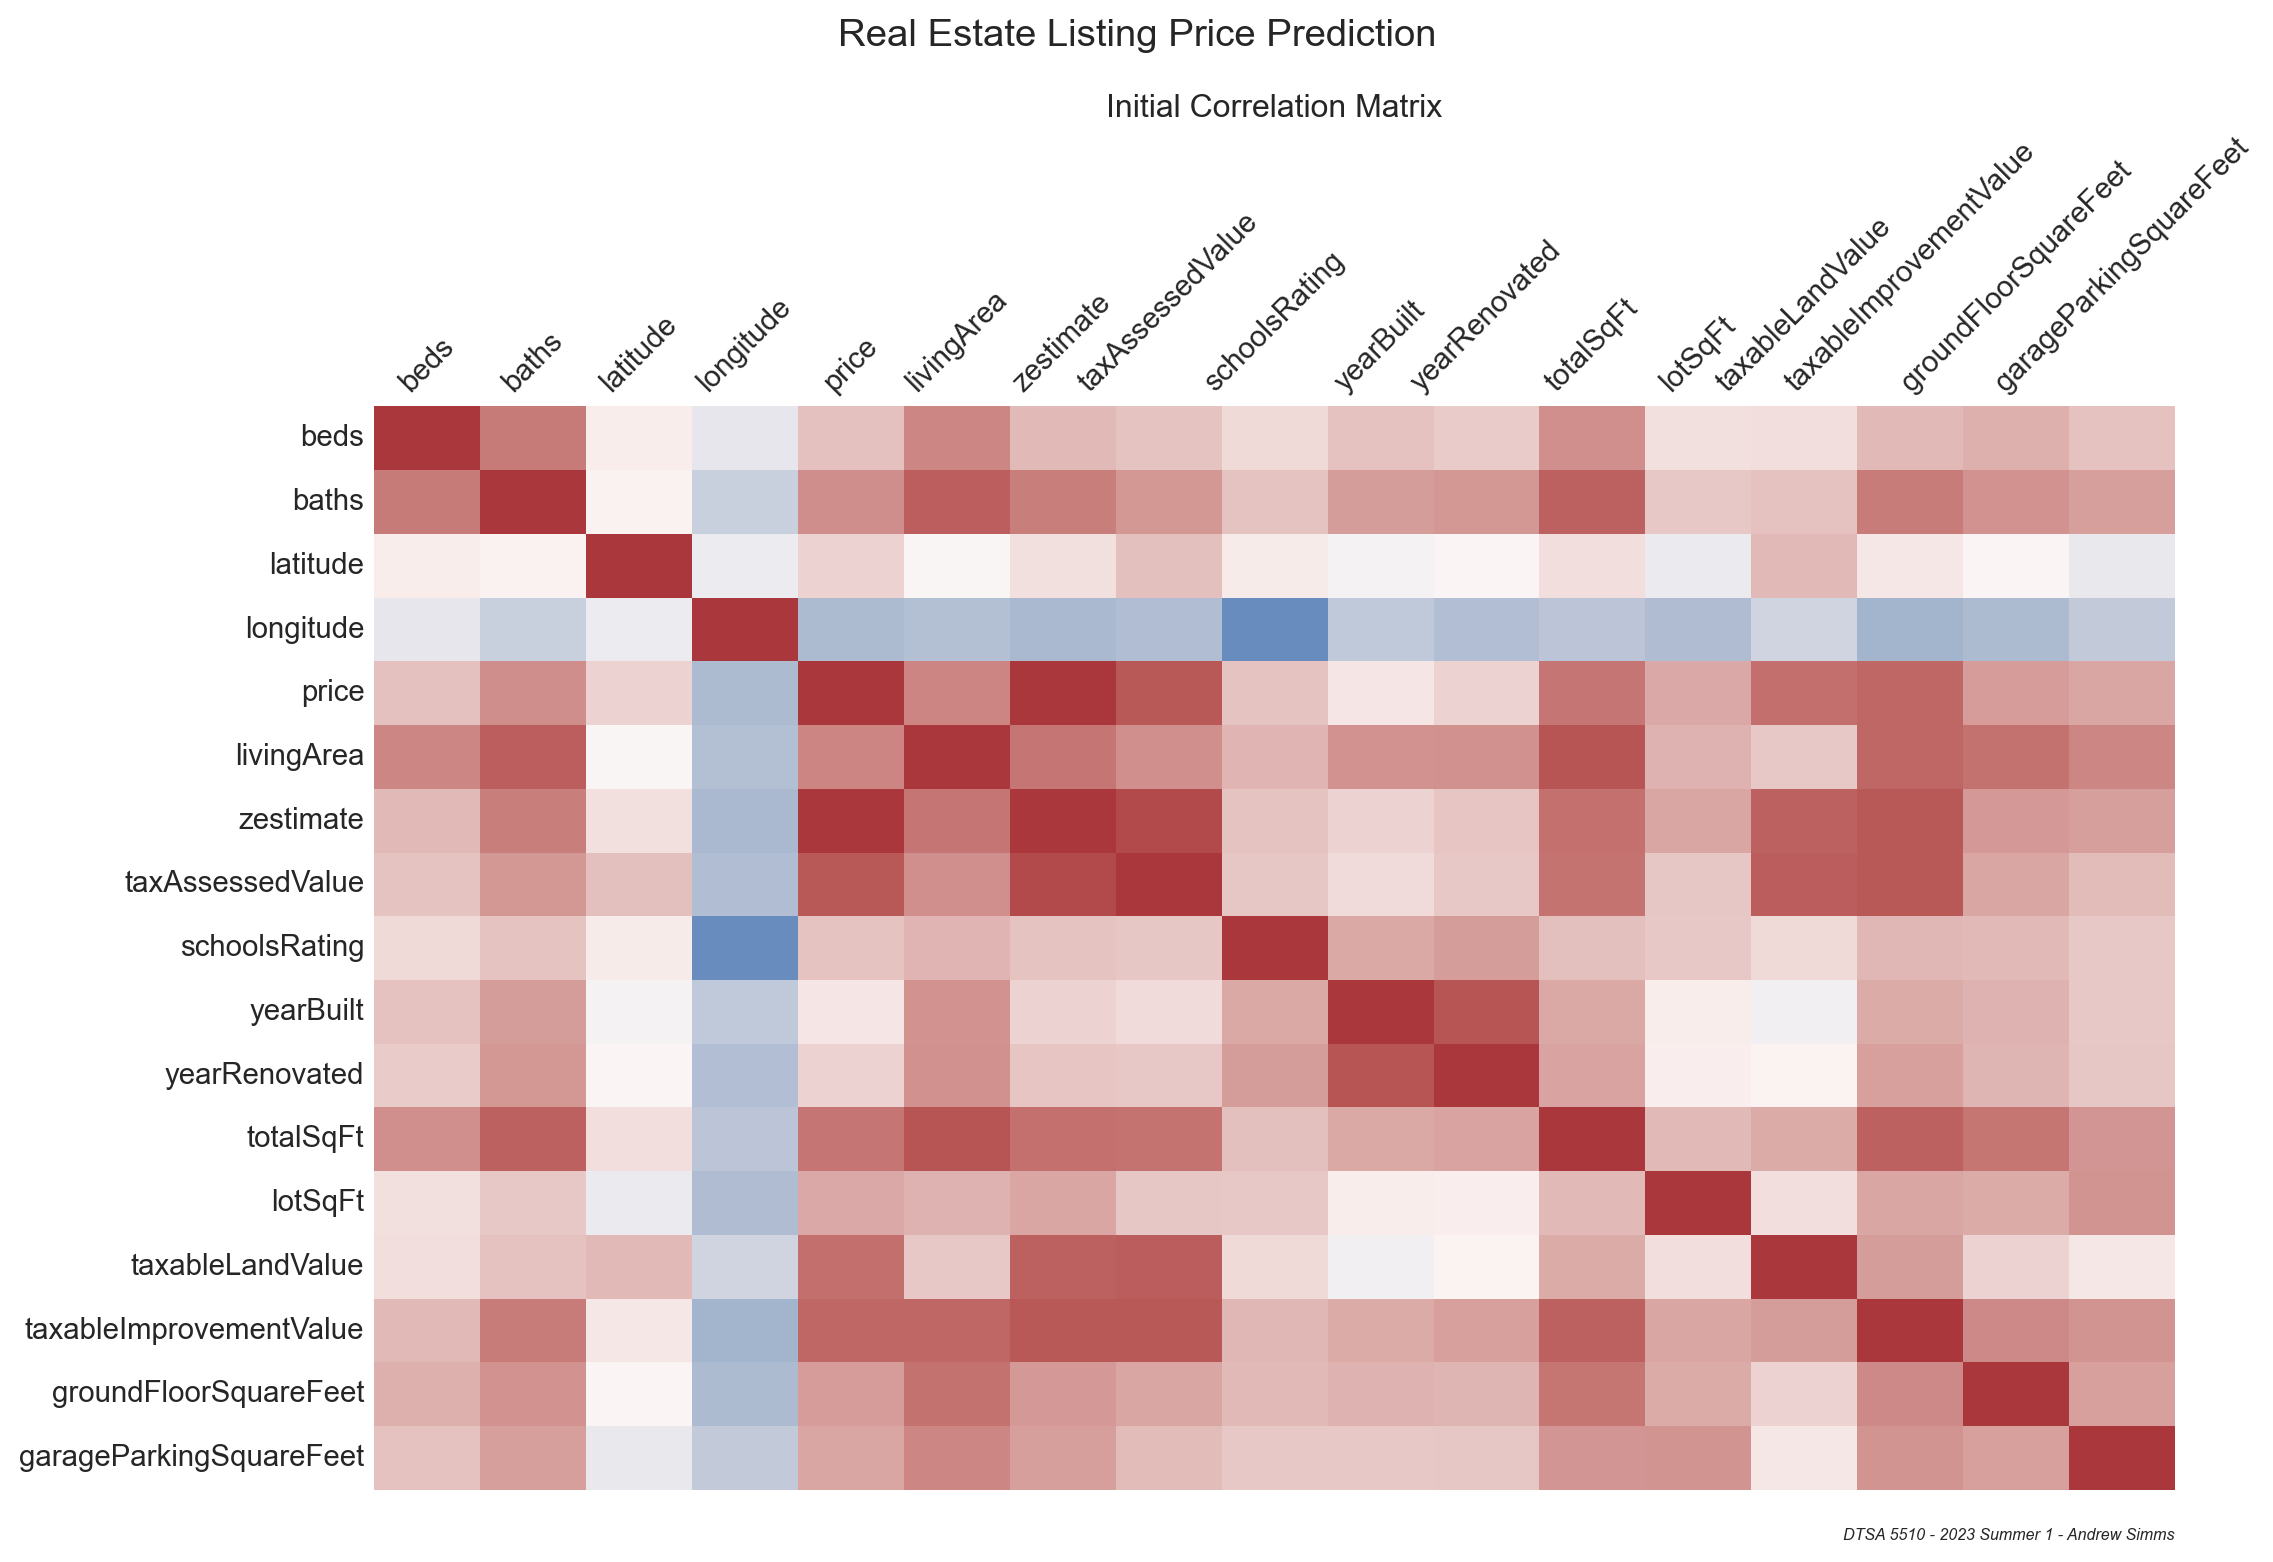

In [39]:
#| label: fig-initial-corr
#| fig-cap: Initial Correlation Matrix of Listings DataFrame

plot_correlation(df, "Initial Correlation Matrix", annot=False, tick_rot=45)

:::

In @fig-initial-corr we see that we have a few strong positive correlations and a large amount of
weak correlations. Overall this visualization provides strong reinforcement that our data is ready
for further work.


## One Hot Encoding (OHE)

One Hot Encoding (OHE) is the process of converting a categorical value into a binary value based on
the category. A categorical value with 5 values will be converted to 5 columns of binary values with
a 1 in the column that the data corresponds to. 

Prior to this conversion it will be helpful to save the column names that are not one hot encoded:


In [40]:
float_cols = [col for col in df.columns if df[col].dtype == 'float64']

In the code below we use pandas `get_dummies`
function to OHE our categorical features:


In [41]:
for col in df.columns:
    if df[col].dtype != "float64":
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = df.drop(col, axis=1)
        df = pd.concat([df, one_hot], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658 entries, 13189295 to 13803132
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   beds                                          656 non-null    float64
 1   baths                                         658 non-null    float64
 2   latitude                                      658 non-null    float64
 3   longitude                                     658 non-null    float64
 4   price                                         658 non-null    float64
 5   livingArea                                    658 non-null    float64
 6   zestimate                                     565 non-null    float64
 7   taxAssessedValue                              652 non-null    float64
 8   schoolsRating                                 658 non-null    float64
 9   yearBuilt                                     625 non

:::{.column-page}


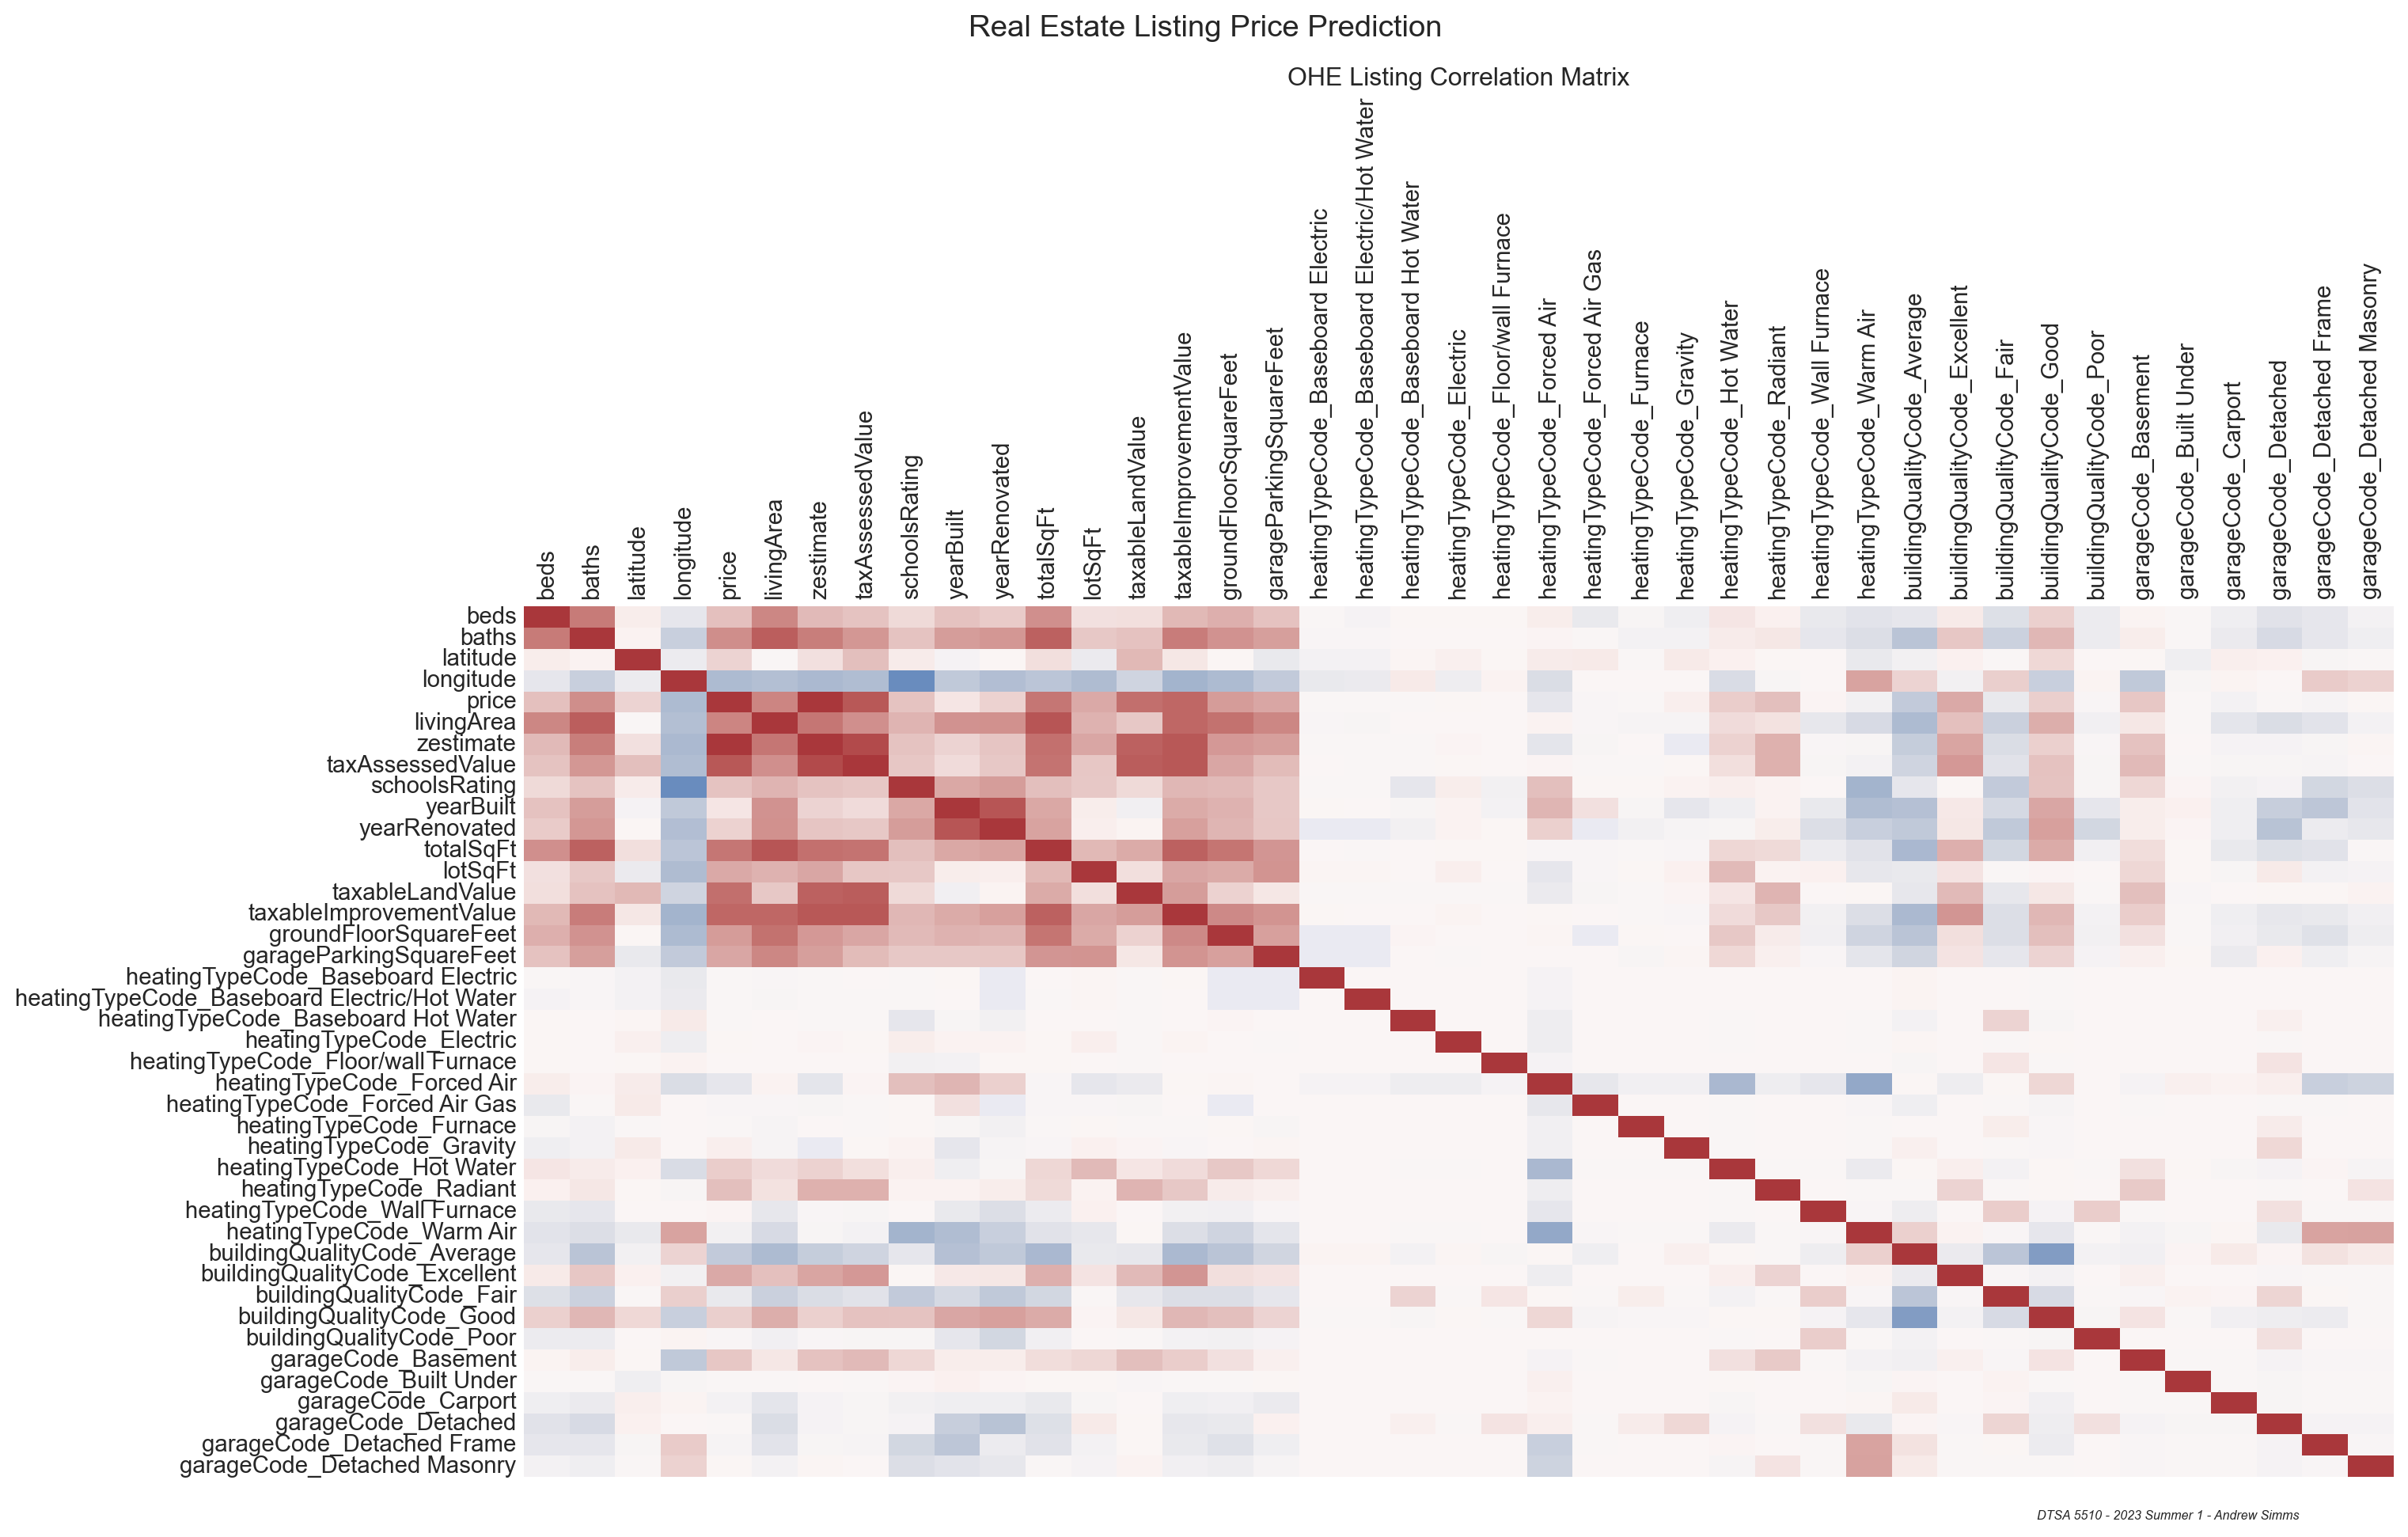

In [42]:
#| label: fig-ohe-corr
#| fig-cap: OHE Correlation Matrix of Listings DataFrame

plot_correlation(df, "OHE Listing Correlation Matrix", annot=False, tick_rot=90, width=16, height=10)

:::

@fig-ohe-corr includes the correlation relationships of the OHE values. We speculate that may add a small amount
of value to to our standard regression models, and may be moderately beneficial for our random forest models.

## Imputation

To ensure a fair comparison between models, we will pass identical data to each model. Some models
have distinct requirements for their input values, and some cannot handle missing values. This
requires that an imputation be performed on the data. For this we will use the `KNNImputer` from
@scikit-learn.


In [43]:
def impute_df(input_df):
    imputer = KNNImputer()
    columns = input_df.columns
    input_df = pd.DataFrame(imputer.fit_transform(input_df))
    input_df.columns = columns
    return input_df


df = impute_df(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   beds                                          658 non-null    float64
 1   baths                                         658 non-null    float64
 2   latitude                                      658 non-null    float64
 3   longitude                                     658 non-null    float64
 4   price                                         658 non-null    float64
 5   livingArea                                    658 non-null    float64
 6   zestimate                                     658 non-null    float64
 7   taxAssessedValue                              658 non-null    float64
 8   schoolsRating                                 658 non-null    float64
 9   yearBuilt                                     658 non-null    flo

## Building Training and Test `DataFrame`s

Now that we have our data frames we can split them into training and test sets. Our target is
going to be `price` and all other columns are going to
be our features. We are using `train_test_split` to partition the data.


In [44]:
test_size = 0.2
random_state = 42
target = "price"

df = df.sort_index()

y = df[target]
z = df["zestimate"]

lat = df["latitude"]
lng = df["longitude"]

# x = df.drop(["price", "zestimate", "latitude", "longitude"], axis=1)
x = df.drop(["price", "zestimate"], axis=1)

x_focus = df.drop(["price", "zestimate", "latitude", "longitude"], axis=1)

x_train, x_test, y_train, y_test, z_train, z_test, lat_test, lat_train, lng_test, lng_train, all_train, all_test, x_focus_train, x_focus_test = train_test_split(
    x, y, z, lat, lng, df, x_focus, test_size=test_size, random_state=random_state
)

## Preparation for Model Comparison

To compare models we need to compute metrics for comparison. We have chosen to compute the mean
squared error (MSE), the root mean squared error (RMSE), and $R^2$. As we are using the same
dataset for all models we can safely use $R^2$ as a comparison. The code below calculates these
values and saves them in `model_stats` for comparison and visualization.


In [45]:
model_stats = {
    "$R^2$": [],
    "Root Mean Squared Error": [],
}

execution_times = {}


def calc_model_stats(name, i_y_test, i_y_pred):
    assert len(i_y_test) == len(
        i_y_pred
    ), "Test and prediction array lengths do not match!"

    calc_mean_squared_error = mean_squared_error(i_y_test, i_y_pred)
    calc_root_mean_squared_error = mean_squared_error(i_y_test, i_y_pred, squared=False)
    calc_mean_absolute_percentage_error = mean_absolute_percentage_error(
        i_y_test, i_y_pred
    )
    calc_r2_score = r2_score(i_y_test, i_y_pred)

    model_stats["Root Mean Squared Error"].append(
        [name, calc_root_mean_squared_error]
    )
    model_stats["$R^2$"].append([name, calc_r2_score])


def plot_model_stats(fig_width=12, fig_height=12):
    num_rows = 2
    num_cols = 1
    fig, axes = plt.subplots(
        nrows=num_rows, ncols=num_cols, figsize=(fig_width, fig_height)
    )

    iteration = 1
    for metric, values in model_stats.items():
        labels = [x[0] for x in values]
        values = [x[1] for x in values]
        plt.subplot(num_rows, num_cols, iteration)
        p = plt.bar(labels, values)
        plt.title(f"{metric} by Model")
        if metric == "$R^2$":
            plt.bar_label(p, ["{:.4f}".format(x) for x in values])
        else:
            plt.bar_label(p, ["{:,}".format(int(x)) for x in values])
        plt.xticks(rotation=-45)
        iteration += 1

    brand_plot()
    plt.show()

# Exploratory Data Analysis (EDA) {#sec-eda}

## Feature Importance {#sec-feat-imp}

To start our EDA, we must build our knowledge of the available features. One way to visualize the
importance of the individual features is to use a random forest algorithm that supports plotting the
importance. One such library is `XGBoost`:

:::{.column-page}


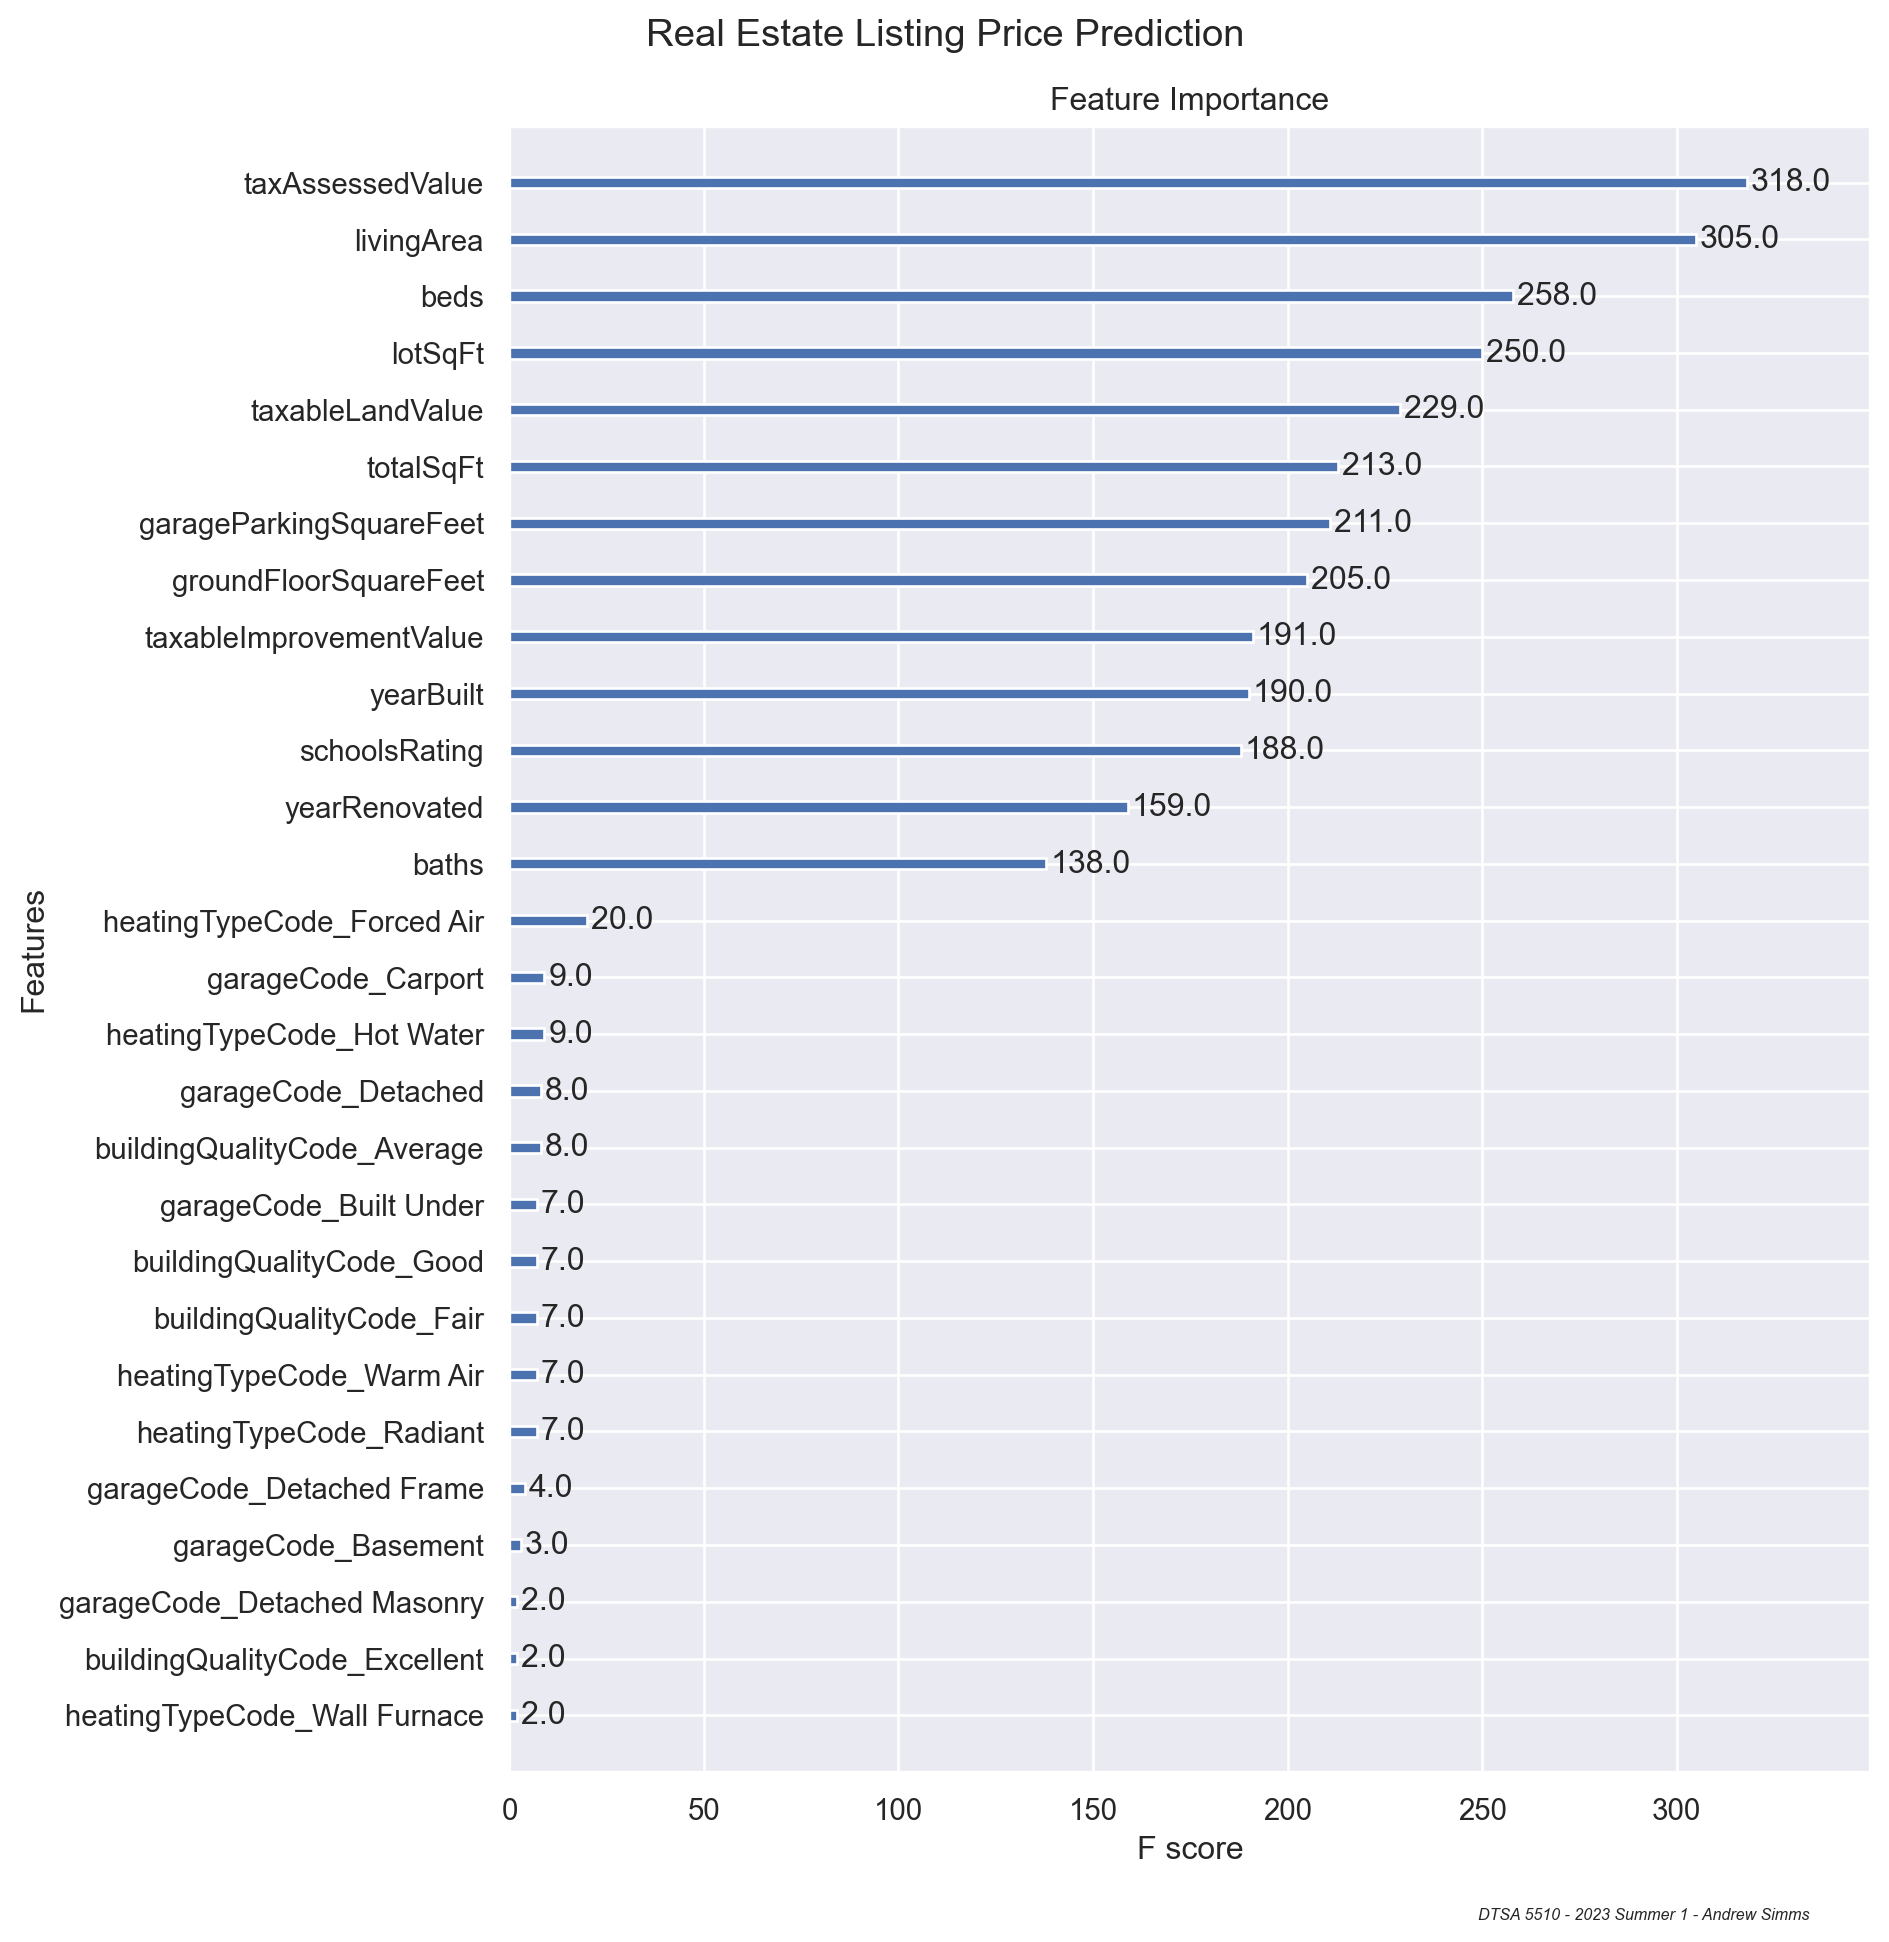

In [46]:
#| label: fig-feat-imp
#| fig-cap: Feature Importance via `XGBoost`

xgb_model = xgb.XGBRegressor(n_jobs=1, booster="gbtree").fit(x_focus_train, y_train)
y_pred = xgb_model.predict(x_focus_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xgb.plot_importance(xgb_model, title="Feature Importance", ax=ax)
brand_plot()
plt.show()

:::

@fig-feat-imp illustrates the importance of `taxAssessedValue` and `livingArea`, which score the
highest. Other floating point features also score preform well, and most binary features score
relatively low. Interestingly, `beds` scored much higher than `baths`. For now we will keep all these features and perform analysis on the most import
columns of data.


## Column Exploration

In this section we will describe and query columns that are immediately relevant to our goal of
predicting real estate listing prices.

### `hdpData_homeInfo_price` {#sec-price-clean}

This column contains the target variable, price, in floating point format. The following code
sections explores this column:


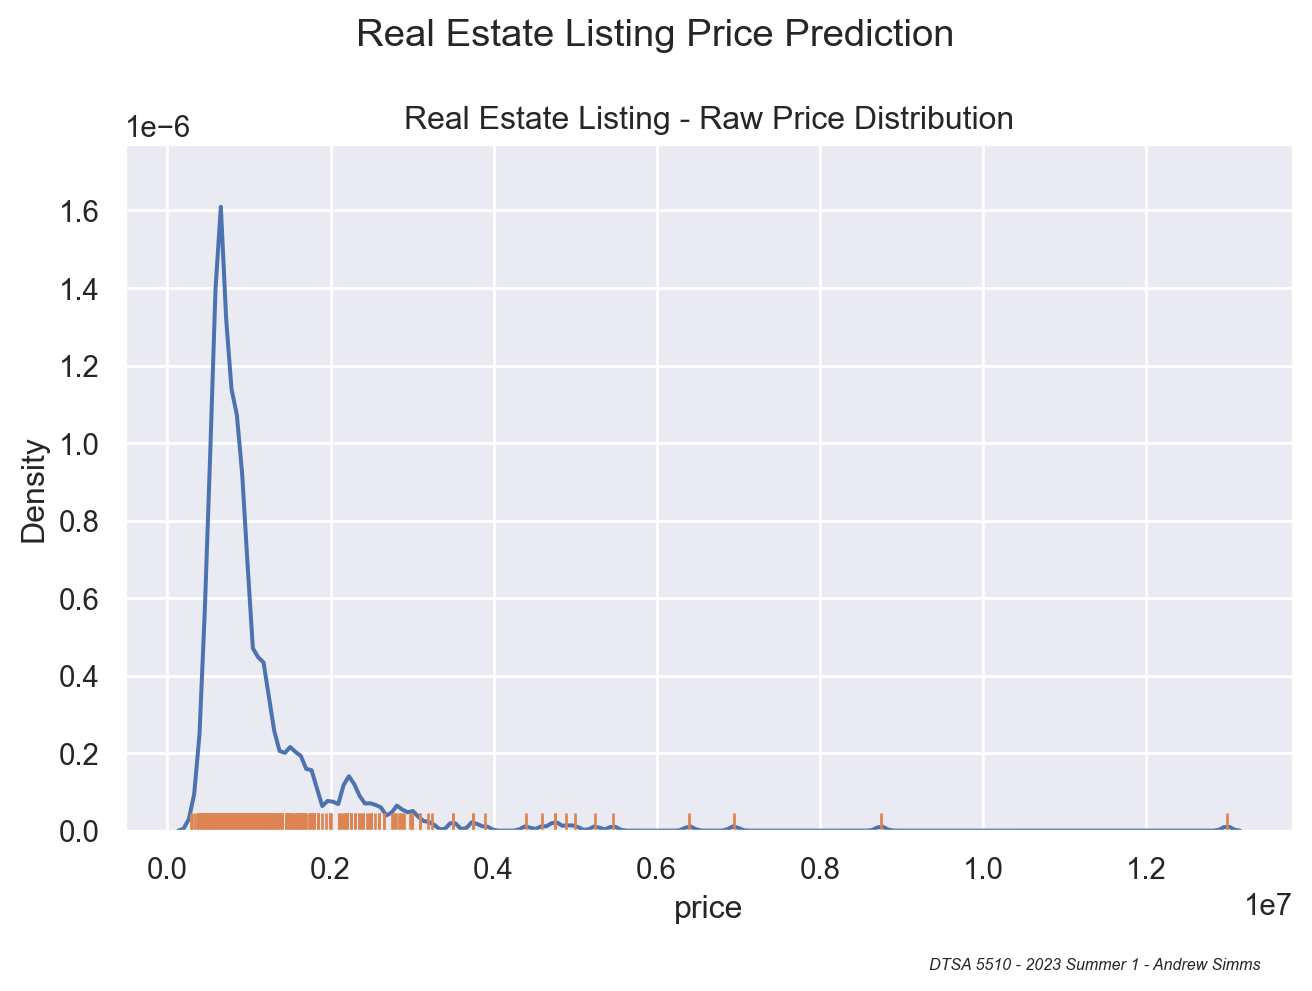

In [47]:
#| label: fig-price-dist
#| fig-cap: '`hdpData_homeInfo_price` column visualized in a KDE plot'

sns.kdeplot(data=df, x="price", bw_adjust=0.2)
sns.rugplot(data=df, x="price")
plt.title("Real Estate Listing - Raw Price Distribution")
brand_plot()

In @fig-price-dist we can see that price is heavily distributed in the bottom fifth of the plot and
that there are many outliers that skew the distribution. In the code below we calculate statistical
descriptions of this column:


In [48]:
df['price'].describe().apply(lambda x: format(x, 'f'))

count         658.000000
mean      1128054.920973
std        974527.892718
min        291000.000000
25%        646583.500000
50%        825000.000000
75%       1200000.000000
max      12995000.000000
Name: price, dtype: object

Now lets zoom in on the data and visualize the prices between the 25% and 75% quantiles:


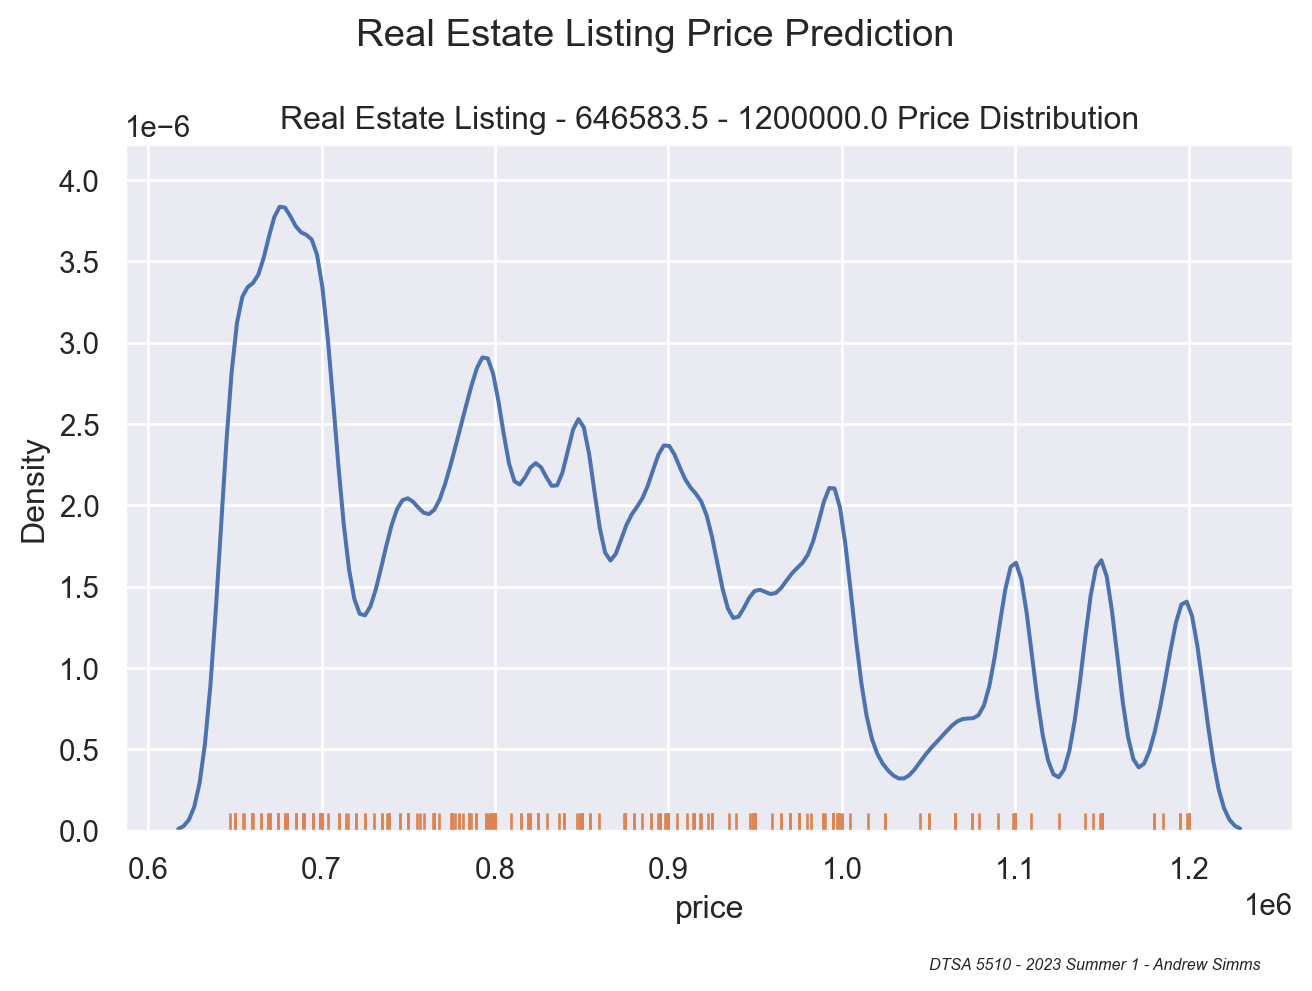

In [49]:
#| label: fig-zoom-price-dist
#| fig-cap: Filtered `price` distribution of quantile 1 - quantile 3

q1, q3 = df['price'].quantile([0.25, 0.75])
price_zoomed_df = df[df['price'].between(q1, q3)]

sns.kdeplot(data=price_zoomed_df, x="price", bw_adjust=0.2)
sns.rugplot(data=price_zoomed_df, x="price")
plt.title(f"Real Estate Listing - {q1} - {q3} Price Distribution")
brand_plot()

In @fig-zoom-price-dist we visualize the central range of the pricing data. Here we can clearly see
that the prices are not evenly distributed, that prices spike at near the 100K threshold for each
price range.

### `taxAssessedValue` {#sec-tax-clean}

This column contains the feature column `taxAssessedValue`. This feature is highly correlated with `price`
and ass seen in @sec-feat-imp, this may be our primary feature for our regression models:


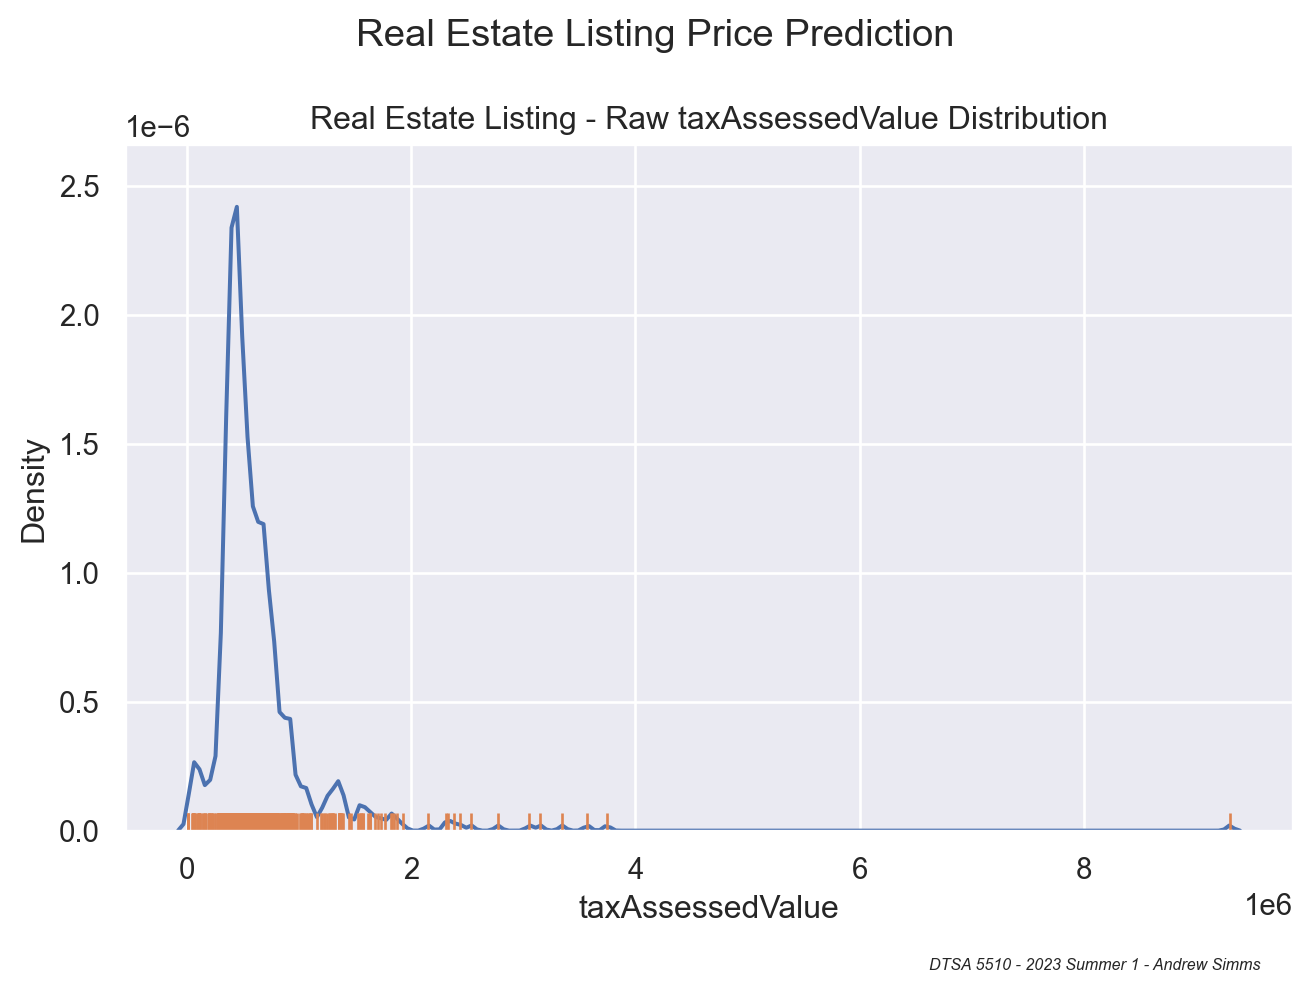

In [50]:
#| label: fig-tax-dist
#| fig-cap: '`taxAssessedValue` feature visualized in a KDE plot'

sns.kdeplot(data=df, x="taxAssessedValue", bw_adjust=0.2)
sns.rugplot(data=df, x="taxAssessedValue")
plt.title("Real Estate Listing - Raw taxAssessedValue Distribution")
brand_plot()

In @fig-tax-dist we see a distribution similar to `price` with a high peak in the lower range and a
long upper tail. 


In [51]:
df['taxAssessedValue'].describe().apply(lambda x: format(x, 'f'))

count        658.000000
mean      648787.675380
std       550837.345364
min        14120.000000
25%       411342.500000
50%       518617.000000
75%       716900.000000
max      9299100.000000
Name: taxAssessedValue, dtype: object

Let's visualize the central section of the density data:


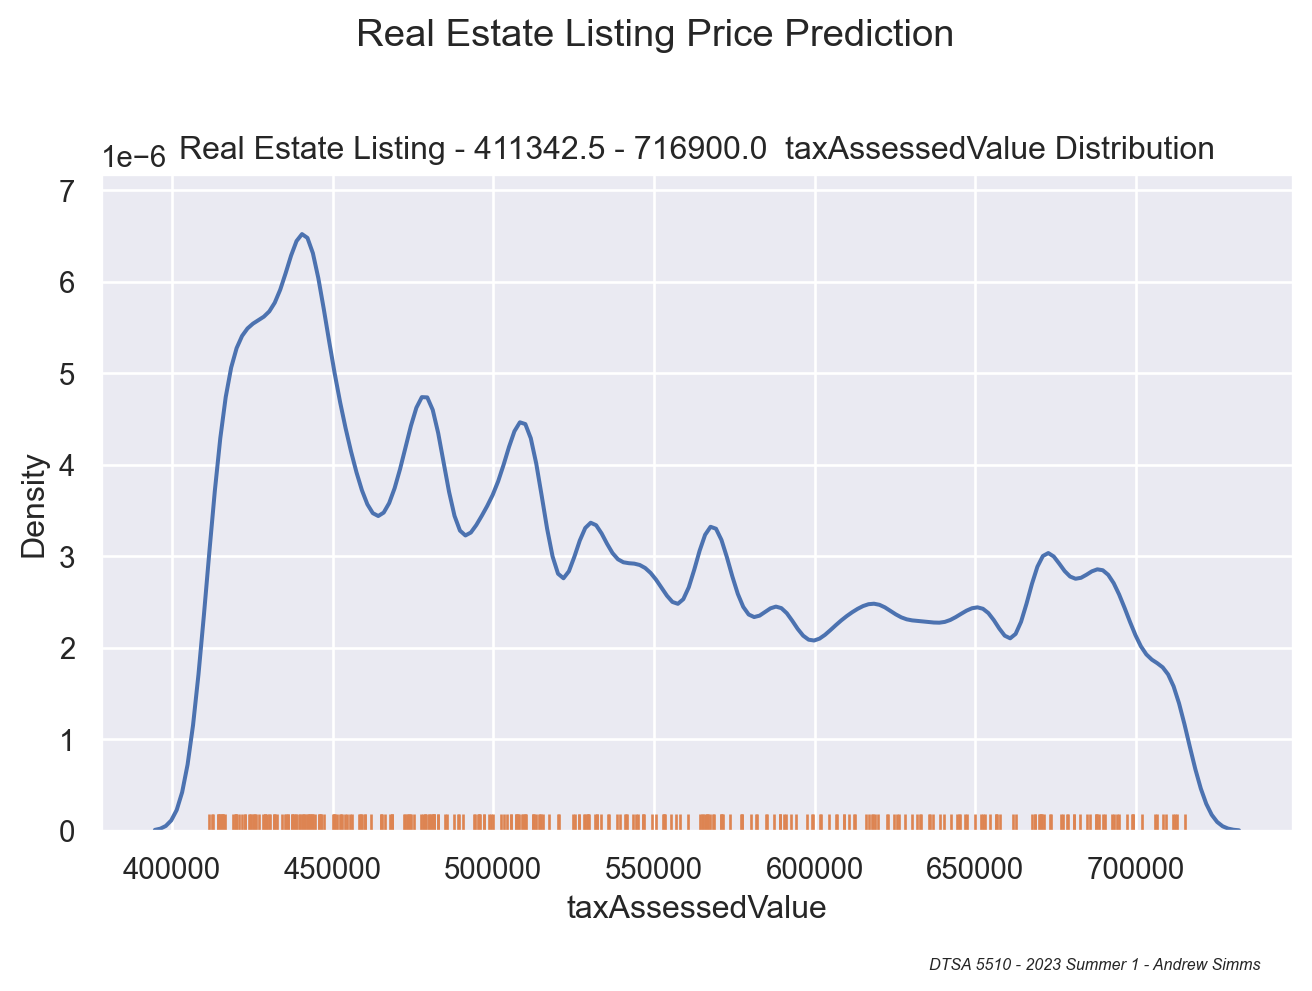

In [52]:
#| label: fig-zoom-tax-dist
#| fig-cap: Filtered `taxAssessedValue` distribution of quantile 1 - quantile 3

q1, q3 = df['taxAssessedValue'].quantile([0.25, 0.75])
price_zoomed_df = df[df['taxAssessedValue'].between(q1, q3)]

sns.kdeplot(data=price_zoomed_df, x="taxAssessedValue", bw_adjust=0.2)
sns.rugplot(data=price_zoomed_df, x="taxAssessedValue")
plt.title(f"Real Estate Listing - {q1} - {q3}  taxAssessedValue Distribution")
brand_plot()

In @fig-zoom-tax-dist we see fewer peaks at the rounded numbers and a smoother distribution. Notice
that the range of this chart is \$400,000 to \$700,000 vs. \$600,000 to \$1,200,000 for `price`.

### `livingArea` {#sec-sqft-clean}

This column contains the feature column `livingArea`. This feature is highly correlated with `price`
and may be another primary feature for our regression models: The following code sections explores this
column:


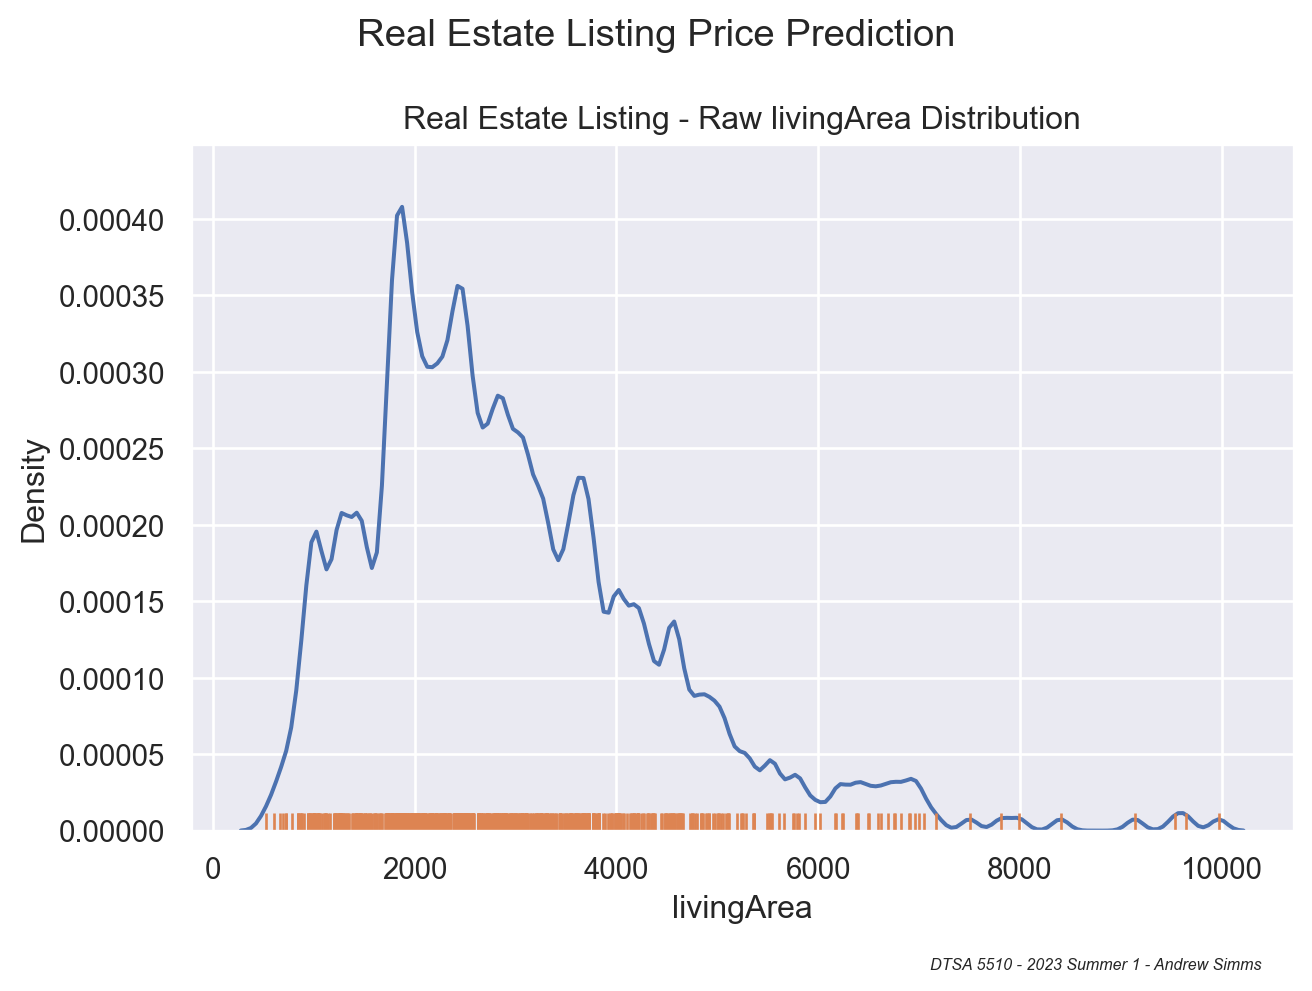

In [53]:
#| label: fig-sqft-dist
#| fig-cap: '`livingArea` feature visualized in a KDE plot'

sns.kdeplot(data=df, x="livingArea", bw_adjust=0.2)
sns.rugplot(data=df, x="livingArea")
plt.title("Real Estate Listing - Raw livingArea Distribution")
brand_plot()

In @fig-sqft-dist we find that most listings are between 1,500 and 3,500 square feet. Just like
`price` above there are many outliers that skew the distribution.


In [54]:
df['livingArea'].describe().apply(lambda x: format(x, 'f'))

count     658.000000
mean     2969.103343
std      1494.572898
min       522.000000
25%      1896.500000
50%      2678.000000
75%      3725.750000
max      9971.000000
Name: livingArea, dtype: object

Now lets zoom in on the data and visualize the square footage between the 25% and 75% quantiles:


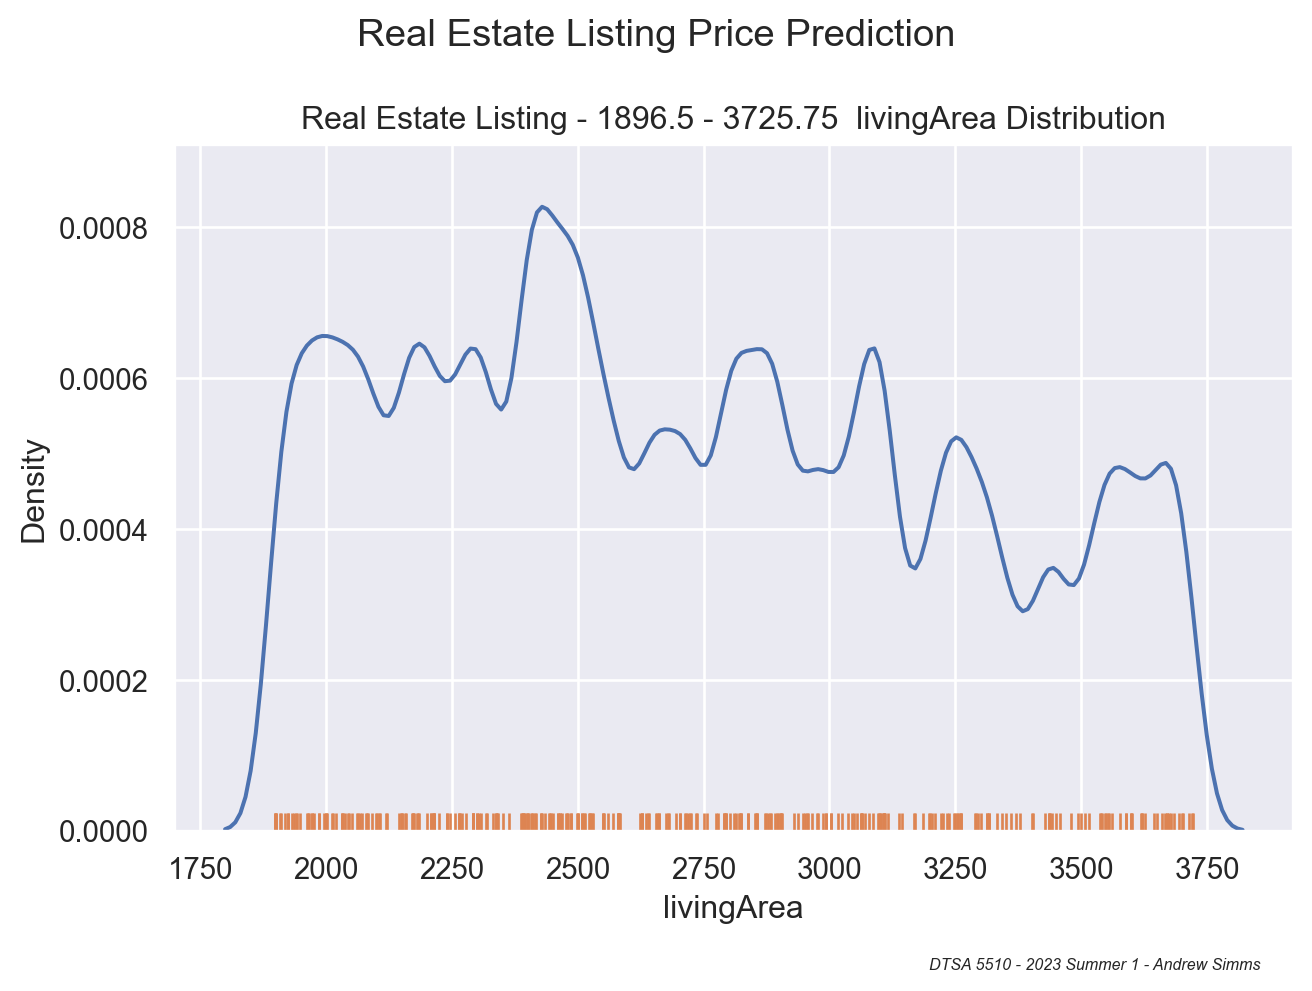

In [55]:
#| label: fig-zoom-sqft-dist
#| fig-cap: Filtered `livingArea` distribution of quantile 1 - quantile 3

q1, q3 = df['livingArea'].quantile([0.25, 0.75])
price_zoomed_df = df[df['livingArea'].between(q1, q3)]

sns.kdeplot(data=price_zoomed_df, x="livingArea", bw_adjust=0.2)
sns.rugplot(data=price_zoomed_df, x="livingArea")
plt.title(f"Real Estate Listing - {q1} - {q3}  livingArea Distribution")
brand_plot()

In @fig-zoom-sqft-dist we find no discernible patterns in the density. As expected, their appears to be an even
distribution of values in the middle of the feature.


## Clustering Visualization

For our unsupervised ML models our plan is to cluster the data then perform a regression on the
clustered data. But how do we choose our clusters? One option is to iterate over many possible
clusters and analyze quality of the clusters using the silhouette score. In the code section below
we create a function, `optmize_clusters` that take a dataframe and two column names and a clustering
model. It then iterates over a number of clusters and calculates the silhouette score, saving the
highest score. In the code section below we build this function:


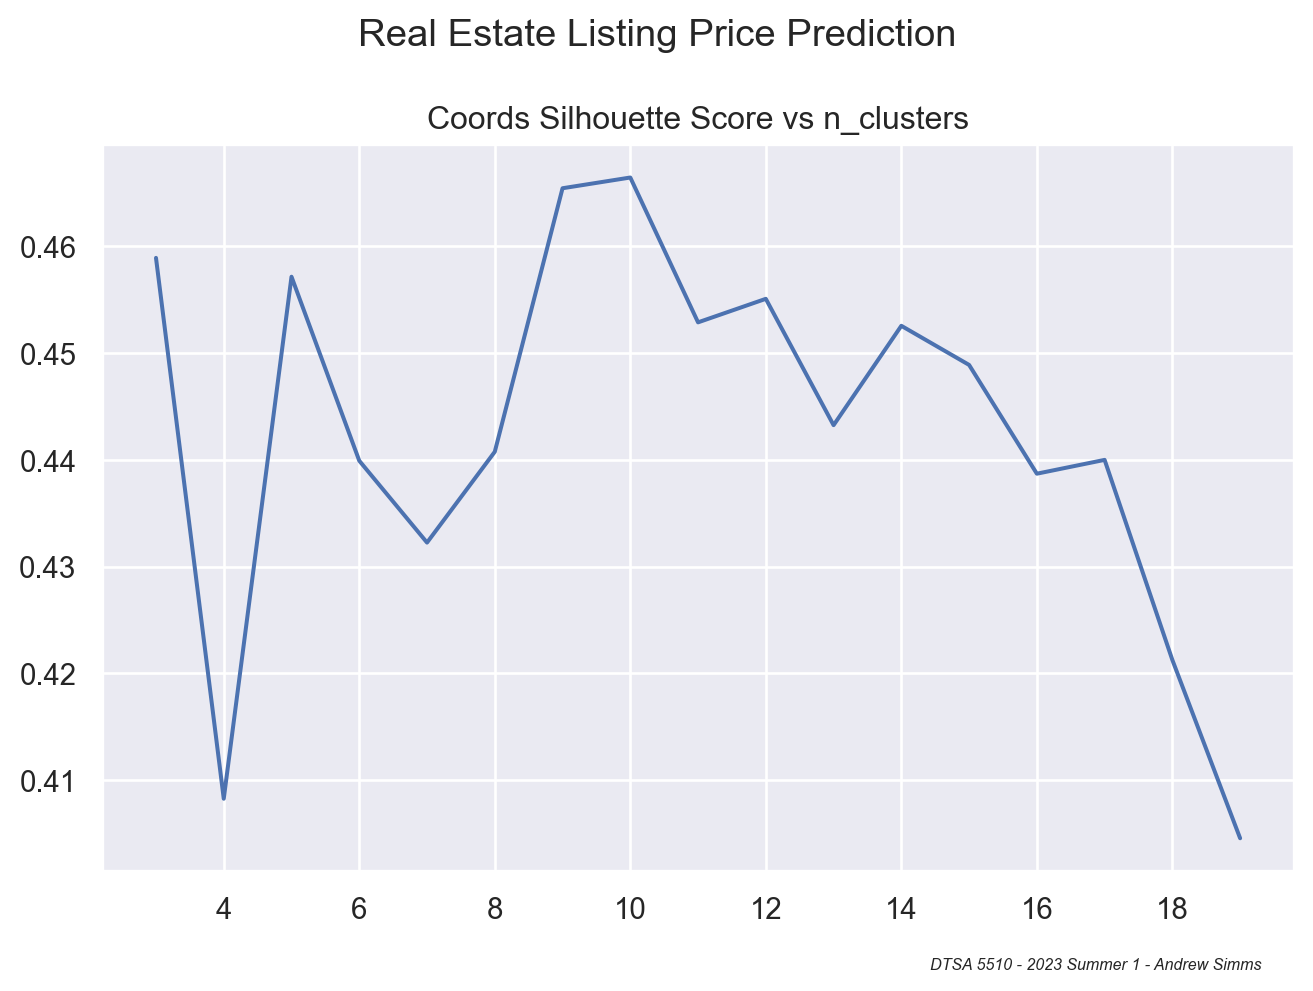

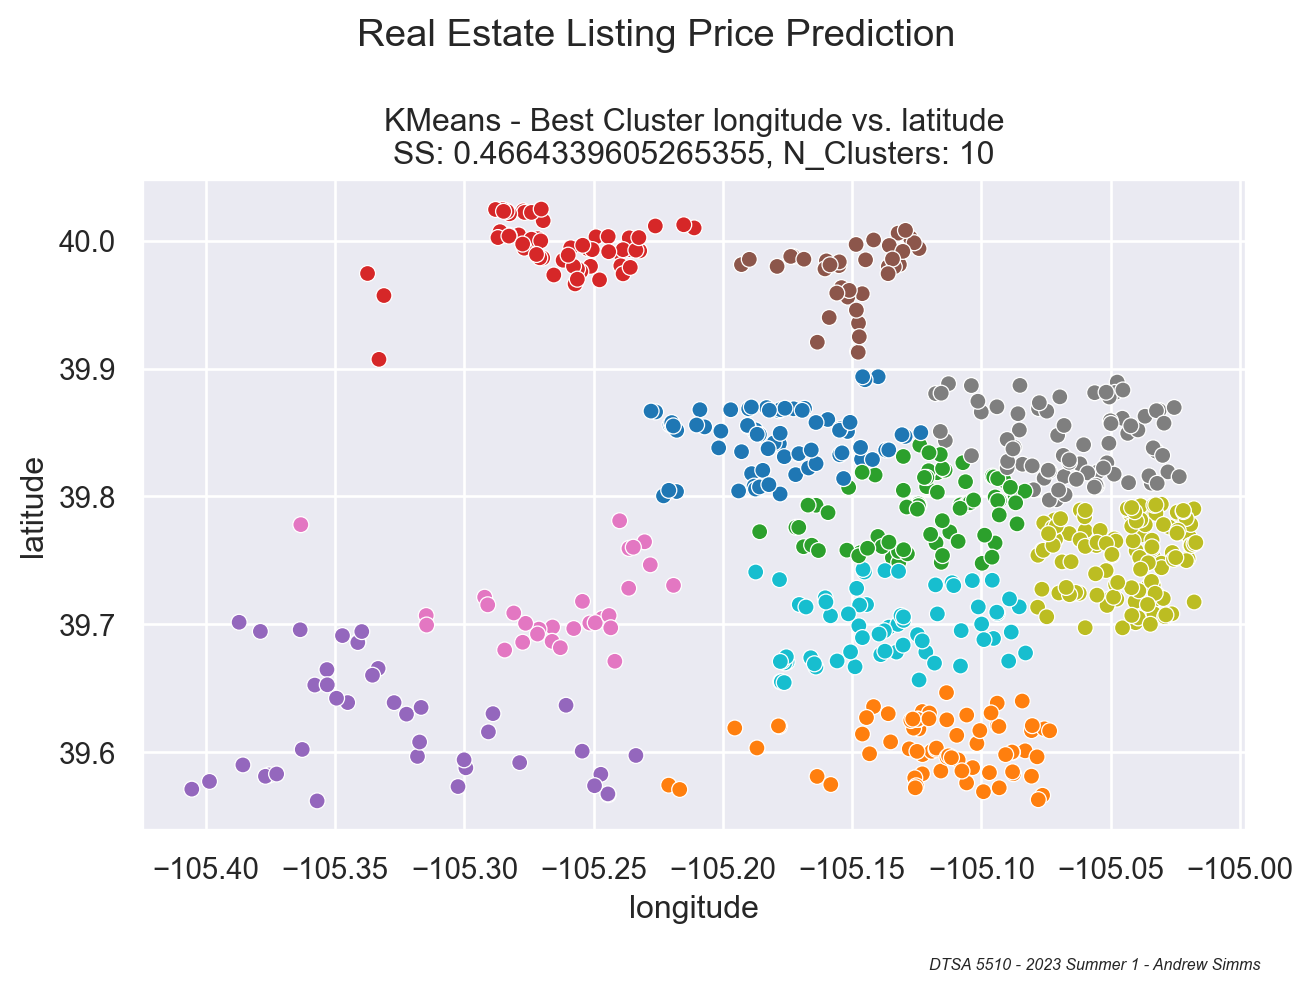

In [56]:
max_all_silhouette_scores = -1
max_all_silhouette_scores_pair = None
max_all_silhouette_scores_n_clusters = 0
max_all_model = None

def optimize_clusters(input_df, x_col, y_col, model, model_label, min_clusters=3, max_clusters=20):
    input_df = input_df.copy()
    lat = input_df[x_col].to_numpy()
    lng = input_df[y_col].to_numpy()

    coords = np.dstack((lat, lng))[0]

    silhouette_scores = []
    max_silhouette_score = -1 
    max_silhouette_score_cluster_num = 0

    for i in range(min_clusters, max_clusters):
        cluster_model = model
        cluster_model.n_clusters = i
        cluster_model.fit(coords)
        this_score = silhouette_score(coords, cluster_model.labels_)
        silhouette_scores.append(this_score)

        if this_score > max_silhouette_score:
            max_silhouette_score = this_score
            max_silhouette_score_cluster_num = i


    plt.title("Coords Silhouette Score vs n_clusters")
    plt.plot(range(min_clusters, max_clusters), silhouette_scores)
    brand_plot()
    plt.show()

    global max_all_silhouette_scores
    global max_all_silhouette_scores_pair
    global max_all_silhouette_scores_n_clusters
    global max_all_model

    best_cluster_model = model
    model.n_clusters = max_silhouette_score_cluster_num
    best_cluster_model.fit(coords)

    if max_silhouette_score > max_all_silhouette_scores:
        max_all_silhouette_scores = max_silhouette_score
        max_all_silhouette_scores_pair = [x_col, y_col]
        max_all_silhouette_scores_n_clusters = max_silhouette_score_cluster_num
        max_all_model = best_cluster_model


    input_df["location_cluster"] = best_cluster_model.labels_

    sns.scatterplot(data=input_df, x=x_col, y=y_col, hue='location_cluster', palette="tab10")
    plt.legend([],[], frameon=False)
    plt.title(f"{model_label} - Best Cluster {x_col} vs. {y_col}\nSS: {max_silhouette_score}, N_Clusters: {max_silhouette_score_cluster_num}")
    brand_plot()
    plt.show()

optimize_clusters(df, "longitude", "latitude", KMeans(init="k-means++", n_init="auto", random_state=42), "KMeans")

# Machine Learning Models {#sec-model}

Our ML models will use a general architecture for price prediction. We will use an
unsupervised ML algorithm to create a subset of the data, and pass this subset to multiple
supervised regression algorithms. The unsupervised ML models will use clustering (`kMeans` and
`AgglomerativeClustering`) and the principal component analysis (`PCA`) to subset the data. The
Supervised ML models will use the regression models, `LinearRegression`, `AdaBoostRegressor`, and
`XGBRegressor`. We will use both root mean squared error (RSME) and $R^2$ to capture the results
from these models. Results for these models will be shared in @sec-results.

## Baseline Single Feature Linear Regression

Our first model will be a baseline comparison of vanilla linear regression. We are using the
scikit-learn implementation and passing in the "most important" feature `taxAssessedValue`:


In [57]:
start = time.time()

linear_regression = LinearRegression()
linear_regression.fit(x_train["taxAssessedValue"].values.reshape(-1, 1), y_train)
y_pred = linear_regression.predict(x_test["taxAssessedValue"].values.reshape(-1, 1))

calc_model_stats(f"LinearRegression", y_test, y_pred)
execution_times["LinearRegression"] = {"duration": time.time() - start}

## Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that encodes high-dimensional data into lower
dimensional data while retaining the most important information. In the code section below we
perform `PCA` for a range of values, calculating $R^2$ at each step and capturing the best result.
In comparison to the clustering algorithms we will see later in this section, this code is
relatively simple. We save the best value of this result as `PCA-{iteration}-{model}`. In this
section we use `LinearRegression` (`LR`), `AdaBoostRegressor` (`AB`) and `XGBRegressor` (`XG`) as
our supervised regression models.


In [58]:
start = time.time()
best_rsquared = 0
best_y_pred = None
best_i = None
best_model = None

for i in range(2, 30):
    pca = PCA(n_components=i)
    x_train_reduced = pca.fit_transform(x_train)
    x_test_reduced = pca.transform(x_test)


    linear_regression = LinearRegression()
    linear_regression.fit(x_train_reduced, y_train)
    y_pred = linear_regression.predict(x_test_reduced)
    calc_r2_score = r2_score(y_pred, y_test)

    if calc_r2_score > best_rsquared:
        best_rsquared = calc_r2_score
        best_y_pred = y_pred
        best_i = i
        best_model = "LR"

    adaboost_model = AdaBoostRegressor(random_state=42, n_estimators=100).fit(
        x_train_reduced, y_train
    )
    y_pred = adaboost_model.predict(x_test_reduced)

    calc_r2_score = r2_score(y_pred, y_test)
    if calc_r2_score > best_rsquared:
        best_rsquared = calc_r2_score
        best_y_pred = y_pred
        best_i = i
        best_model = "AB"

    booster = "gbtree"
    xgb_model = xgb.XGBRegressor(n_jobs=1, booster=booster).fit(x_train_reduced, y_train)
    y_pred = xgb_model.predict(x_test_reduced)

    calc_r2_score = r2_score(y_pred, y_test)
    if calc_r2_score > best_rsquared:
        best_rsquared = calc_r2_score
        best_y_pred = y_pred
        best_i = i
        best_model = "XG"

calc_model_stats(f"PCA {best_i}-{best_model}", y_test, best_y_pred)
execution_times[f"PCA {best_i}-{best_model}"] = {"duration": time.time() - start}

## Feature Selection

To the cluster modeling process we create an optimized list of features it `selected_features_list`.
This list represents the best performing features by length, i.e. the first item in the list is the
best performing single feature, the second item in the list is the best performing double feature,
etc. We do this by using the "scikit-learn" `SelectKBest` library. Additionally, we use linear
regression to compute a model with these features and save the result at the `SelectKBestLR` model.


In [59]:
start = time.time()
best_rsquared = 0
best_features = None
best_y_pred = None
selected_features_list = []

for i in range(2, len(x_train.columns) - 1):
    selector = SelectKBest(score_func=f_regression, k=i)
    X_reduced = selector.fit_transform(x_train, y_train)
    selected_features = pd.DataFrame(
        selector.inverse_transform(X_reduced),
        index=x_train.index,
        columns=x_train.columns,
    )

    selected_columns = selected_features.columns[selected_features.var() != 0]
    selected_features_list.append(list(selected_columns))

    X_reduced = x_train[selected_columns]
    linear_regression = LinearRegression()
    linear_regression.fit(x_train[selected_columns], y_train)
    y_pred = linear_regression.predict(x_test[selected_columns])

    calc_r2_score = r2_score(y_pred, y_test)
    if calc_r2_score > best_rsquared:
        best_rsquared = calc_r2_score
        best_features = selected_columns
        best_y_pred = y_pred

calc_model_stats("SelectKBestLR", y_test, best_y_pred)
execution_times["SelectKBestLR"] = {"duration": time.time() - start}

In [60]:
print(selected_features_list)

[['taxAssessedValue', 'taxableLandValue'], ['taxAssessedValue', 'taxableLandValue', 'taxableImprovementValue'], ['taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue'], ['livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue'], ['baths', 'livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue'], ['baths', 'livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue', 'heatingTypeCode_Radiant'], ['baths', 'livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue', 'heatingTypeCode_Radiant', 'buildingQualityCode_Excellent'], ['baths', 'livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue', 'garageParkingSquareFeet', 'heatingTypeCode_Radiant', 'buildingQualityCode_Excellent'], ['baths', 'livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue', 'groundFloor

## Cluster Selection

This section focuses on calculating the highest scoring feature columns for a given number of
clusters. We use the `silhouette_score` as the metric calculating the quality of the clusters. The
class `ClusterFeatureSelector` creates a permutation of column names and iterates over these and the
number of clusters and calculates the `silhouette_score`. We save the best cluster score and feature
columns in `best_cluster_features` and return them from `build_by_dimension`. It is recommended to
keep the `dimension` argument low (2 or 3) to avoid long run times.


In [61]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 5


class ClusterFeatureSelector:
    def __init__(
        self,
        input_df,
        input_cols,
        model,
        min_clusters=MIN_CLUSTERS,
        max_clusters=MAX_CLUSTERS,
    ):
        cluster_cols = input_cols.copy()

        cluster_cols.remove("price")
        cluster_cols.remove("zestimate")
        cluster_cols.remove("beds")
        cluster_cols.remove("baths")

        self.cluster_features = cluster_cols
        self.input_df = input_df
        self.model = model

        self.min_clusters = min_clusters
        self.max_clusters = max_clusters

    def build_by_dimension(self, dimension):
        best_cluster_features = {}

        feature_combinations = list(
            itertools.combinations(self.cluster_features, dimension)
        )

        for feature_combo in feature_combinations:
            input_df = self.input_df.copy()
            cluster_input_list = list([input_df[i].to_numpy() for i in feature_combo])

            cluster_input = np.dstack(cluster_input_list)[0]

            for i in range(self.min_clusters, self.max_clusters + 1):
                cluster_model = copy.copy(self.model)
                cluster_model.n_clusters = i
                cluster_model.fit(cluster_input)
                this_score = silhouette_score(cluster_input, cluster_model.labels_)

                if i not in best_cluster_features:
                    best_cluster_features[i] = {"sil_score": 0, "features": None}

                if this_score > best_cluster_features[i]["sil_score"]:
                    best_cluster_features[i]["sil_score"] = this_score
                    best_cluster_features[i]["features"] = feature_combo

        return best_cluster_features

In [62]:
start = time.time()
clusterFeatureSelector = ClusterFeatureSelector(df, float_cols, KMeans(init="k-means++", n_init=20, random_state=42))
two_d_cluster_features = clusterFeatureSelector.build_by_dimension(2)
execution_times["TwoDClusterSelection"] = {"duration": time.time() - start}

# three_d_cluster_features = clusterFeatureSelector.build_by_dimension(3)
# print(three_d_cluster_features)

## Regression Using Clusters

The `ClusterRegression` class breaks the dataset up into smaller clusters and runs a regression
algorithm on these clusters. In theory this seems like a simple concept, but it introduces many
variables in the form of feature selection, cluster selection, and number of clusters. To solve this
we pre calculate the best features and clusters in the previous two sections. We use these here to
find the optimal cluster. Th


In [63]:
class ClusterRegression:
    def __init__(
        self,
        train,
        test,
        target,
        cluster_model,
        regression_model,
        min_clusters=MIN_CLUSTERS,
        max_clusters=MAX_CLUSTERS,
    ):
        self.train = train
        self.test = test
        self.target = target
        self.cluster_model = cluster_model
        self.regression_model = regression_model
        self.min_clusters = min_clusters
        self.max_clusters = max_clusters
        self.best_rsquared = 0
        self.best_regression_features = None
        self.best_cluster_features = None
        self.best_n_clusters = None
        self.best_pred = None

    def find_optimal_cluster(self, regression_features, cluster_features):
        train_df = self.train.copy()
        test_df = self.test.copy()

        for regression_feat_cols in regression_features:
            for cluster_num in cluster_features.keys():
                this_regression_features = regression_feat_cols
                this_cluster_features = cluster_features[cluster_num]["features"]
                n_clusters = cluster_num

                train_cluster_input_list = list([train_df[i].to_numpy() for i in this_cluster_features])
                test_cluster_input_list = list([test_df[i].to_numpy() for i in this_cluster_features])

                train_cluster_input = np.dstack(train_cluster_input_list)[0]
                test_cluster_input = np.dstack(test_cluster_input_list)[0]
                this_train_df = train_df.copy()
                this_test_df = test_df.copy()

                cluster_model = copy.copy(self.cluster_model)
                cluster_model.n_clusters = cluster_num
                cluster_model.fit(train_cluster_input)
                this_train_df["cluster_label"] = cluster_model.labels_
                train_labels = cluster_model.labels_
                test_labels = cluster_model.fit_predict(test_cluster_input)
                this_test_df["cluster_label"] = test_labels

                # Build test and train dataframes for each cluster
                train_clusters = {label: pd.DataFrame() for label in train_labels}
                for key in train_clusters.keys():
                    train_clusters[key] = this_train_df[:][this_train_df['cluster_label'] == key]

                test_clusters = {label: pd.DataFrame() for label in test_labels}
                for key in test_clusters.keys():
                    test_clusters[key] = this_test_df[:][this_test_df['cluster_label'] == key]

                test_cluster_df_list = []
                for key in train_clusters.keys():
                    train_cluster_df = train_clusters[key]
                    test_cluster_df = test_clusters[key]
                    regression_model = copy.copy(self.regression_model)
                    regression_model = self.regression_model.fit(train_cluster_df[this_regression_features], train_cluster_df[self.target])
                    cluster_y_pred = regression_model.predict(test_cluster_df[this_regression_features])
                    test_cluster_df["y_pred"] = cluster_y_pred
                    test_cluster_df_list.append(test_cluster_df)

                pred_df = pd.concat(test_cluster_df_list)
                pred_df = pred_df.sort_index()

                test_pred = y_test.sort_index()
                rsquared = r2_score(test_pred, pred_df['y_pred'])

                if rsquared > self.best_rsquared:
                    self.best_rsquared = rsquared
                    self.best_regression_features = this_regression_features
                    self.best_cluster_features = this_cluster_features
                    self.best_n_clusters = cluster_num
                    self.best_pred = pred_df['y_pred']

        print(f"Best:\n\tR2: {self.best_rsquared}\n\tRegression: {self.best_regression_features}\n\tCluster: {self.best_cluster_features}\n\tn_clusters: {self.best_n_clusters}")
        print()

    def get_best_rsquared(self):
        return self.best_rsquared

    def get_best_pred(self):
        return self.best_pred

    def get_best_features(self):
        return self.best_features

    def get_best_clusters(self):
        return self.best_clusters

In [64]:
start = time.time()
linear_cluster_regressor = ClusterRegression(all_train, all_test, target, KMeans(init="k-means++", n_init="auto", random_state=42), LinearRegression())
linear_cluster_regressor.find_optimal_cluster(selected_features_list, two_d_cluster_features)
y_pred_lcr = linear_cluster_regressor.get_best_pred()

calc_model_stats("OptClusterLinReg", y_test.sort_index(), y_pred_lcr)
execution_times["OptClusterLinReg"] = {"duration": time.time() - start}

Best:
	R2: 0.7043705679765464
	Regression: ['beds', 'baths', 'latitude', 'longitude', 'livingArea', 'taxAssessedValue', 'schoolsRating', 'yearRenovated', 'totalSqFt', 'lotSqFt', 'taxableLandValue', 'taxableImprovementValue', 'groundFloorSquareFeet', 'garageParkingSquareFeet', 'heatingTypeCode_Hot Water', 'heatingTypeCode_Radiant', 'buildingQualityCode_Average', 'buildingQualityCode_Excellent', 'buildingQualityCode_Fair', 'buildingQualityCode_Good', 'garageCode_Basement']
	Cluster: ('longitude', 'lotSqFt')
	n_clusters: 3



In [65]:
start = time.time()
xgb_cluster_regressor = ClusterRegression(all_train, all_test, target, KMeans(init="k-means++", n_init="auto", random_state=42), xgb.XGBRegressor(n_jobs=1, booster="gbtree"))
xgb_cluster_regressor.find_optimal_cluster(selected_features_list, two_d_cluster_features)
y_pred_xgbcr = xgb_cluster_regressor.get_best_pred()

calc_model_stats("OptClusterXGB", y_test.sort_index(), y_pred_xgbcr)
execution_times["OptClusterXGB"] = {"duration": time.time() - start}

Best:
	R2: 0.6773678780373913
	Regression: ['baths', 'livingArea', 'taxAssessedValue', 'totalSqFt', 'taxableLandValue', 'taxableImprovementValue', 'garageParkingSquareFeet', 'heatingTypeCode_Radiant', 'buildingQualityCode_Excellent']
	Cluster: ('longitude', 'lotSqFt')
	n_clusters: 3



## Neural Network

For complete comparison of modeling techniques we are a naive neural network models to see if they
offer additional accuracy when compared to the supervised and unsupervised ML algorithms. This is by
no means an optimized or tuned version of a neural network.


In [66]:
start = time.time()

input_shape = x_train.shape[1]

# Scale the input data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Define learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with early stopping and reduced learning rate
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)

model.fit(x_train_scaled, y_train, epochs=50, batch_size=32, verbose=0,
          validation_data=(x_test_scaled, y_test),
          callbacks=[early_stopping, reduce_lr])

# Make predictions on x_test
y_pred = model.predict(x_test_scaled)

calc_model_stats("NeuralNetwork", y_test, y_pred)
execution_times["NeuralNetwork"] = {"duration": time.time() - start}

1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 1ms/step


# Results \& Analysis {#sec-results}

## Model Accuracy Results

@fig-model-results compares the results of the model accuracy computations in a bar plot:

:::{.column-page}


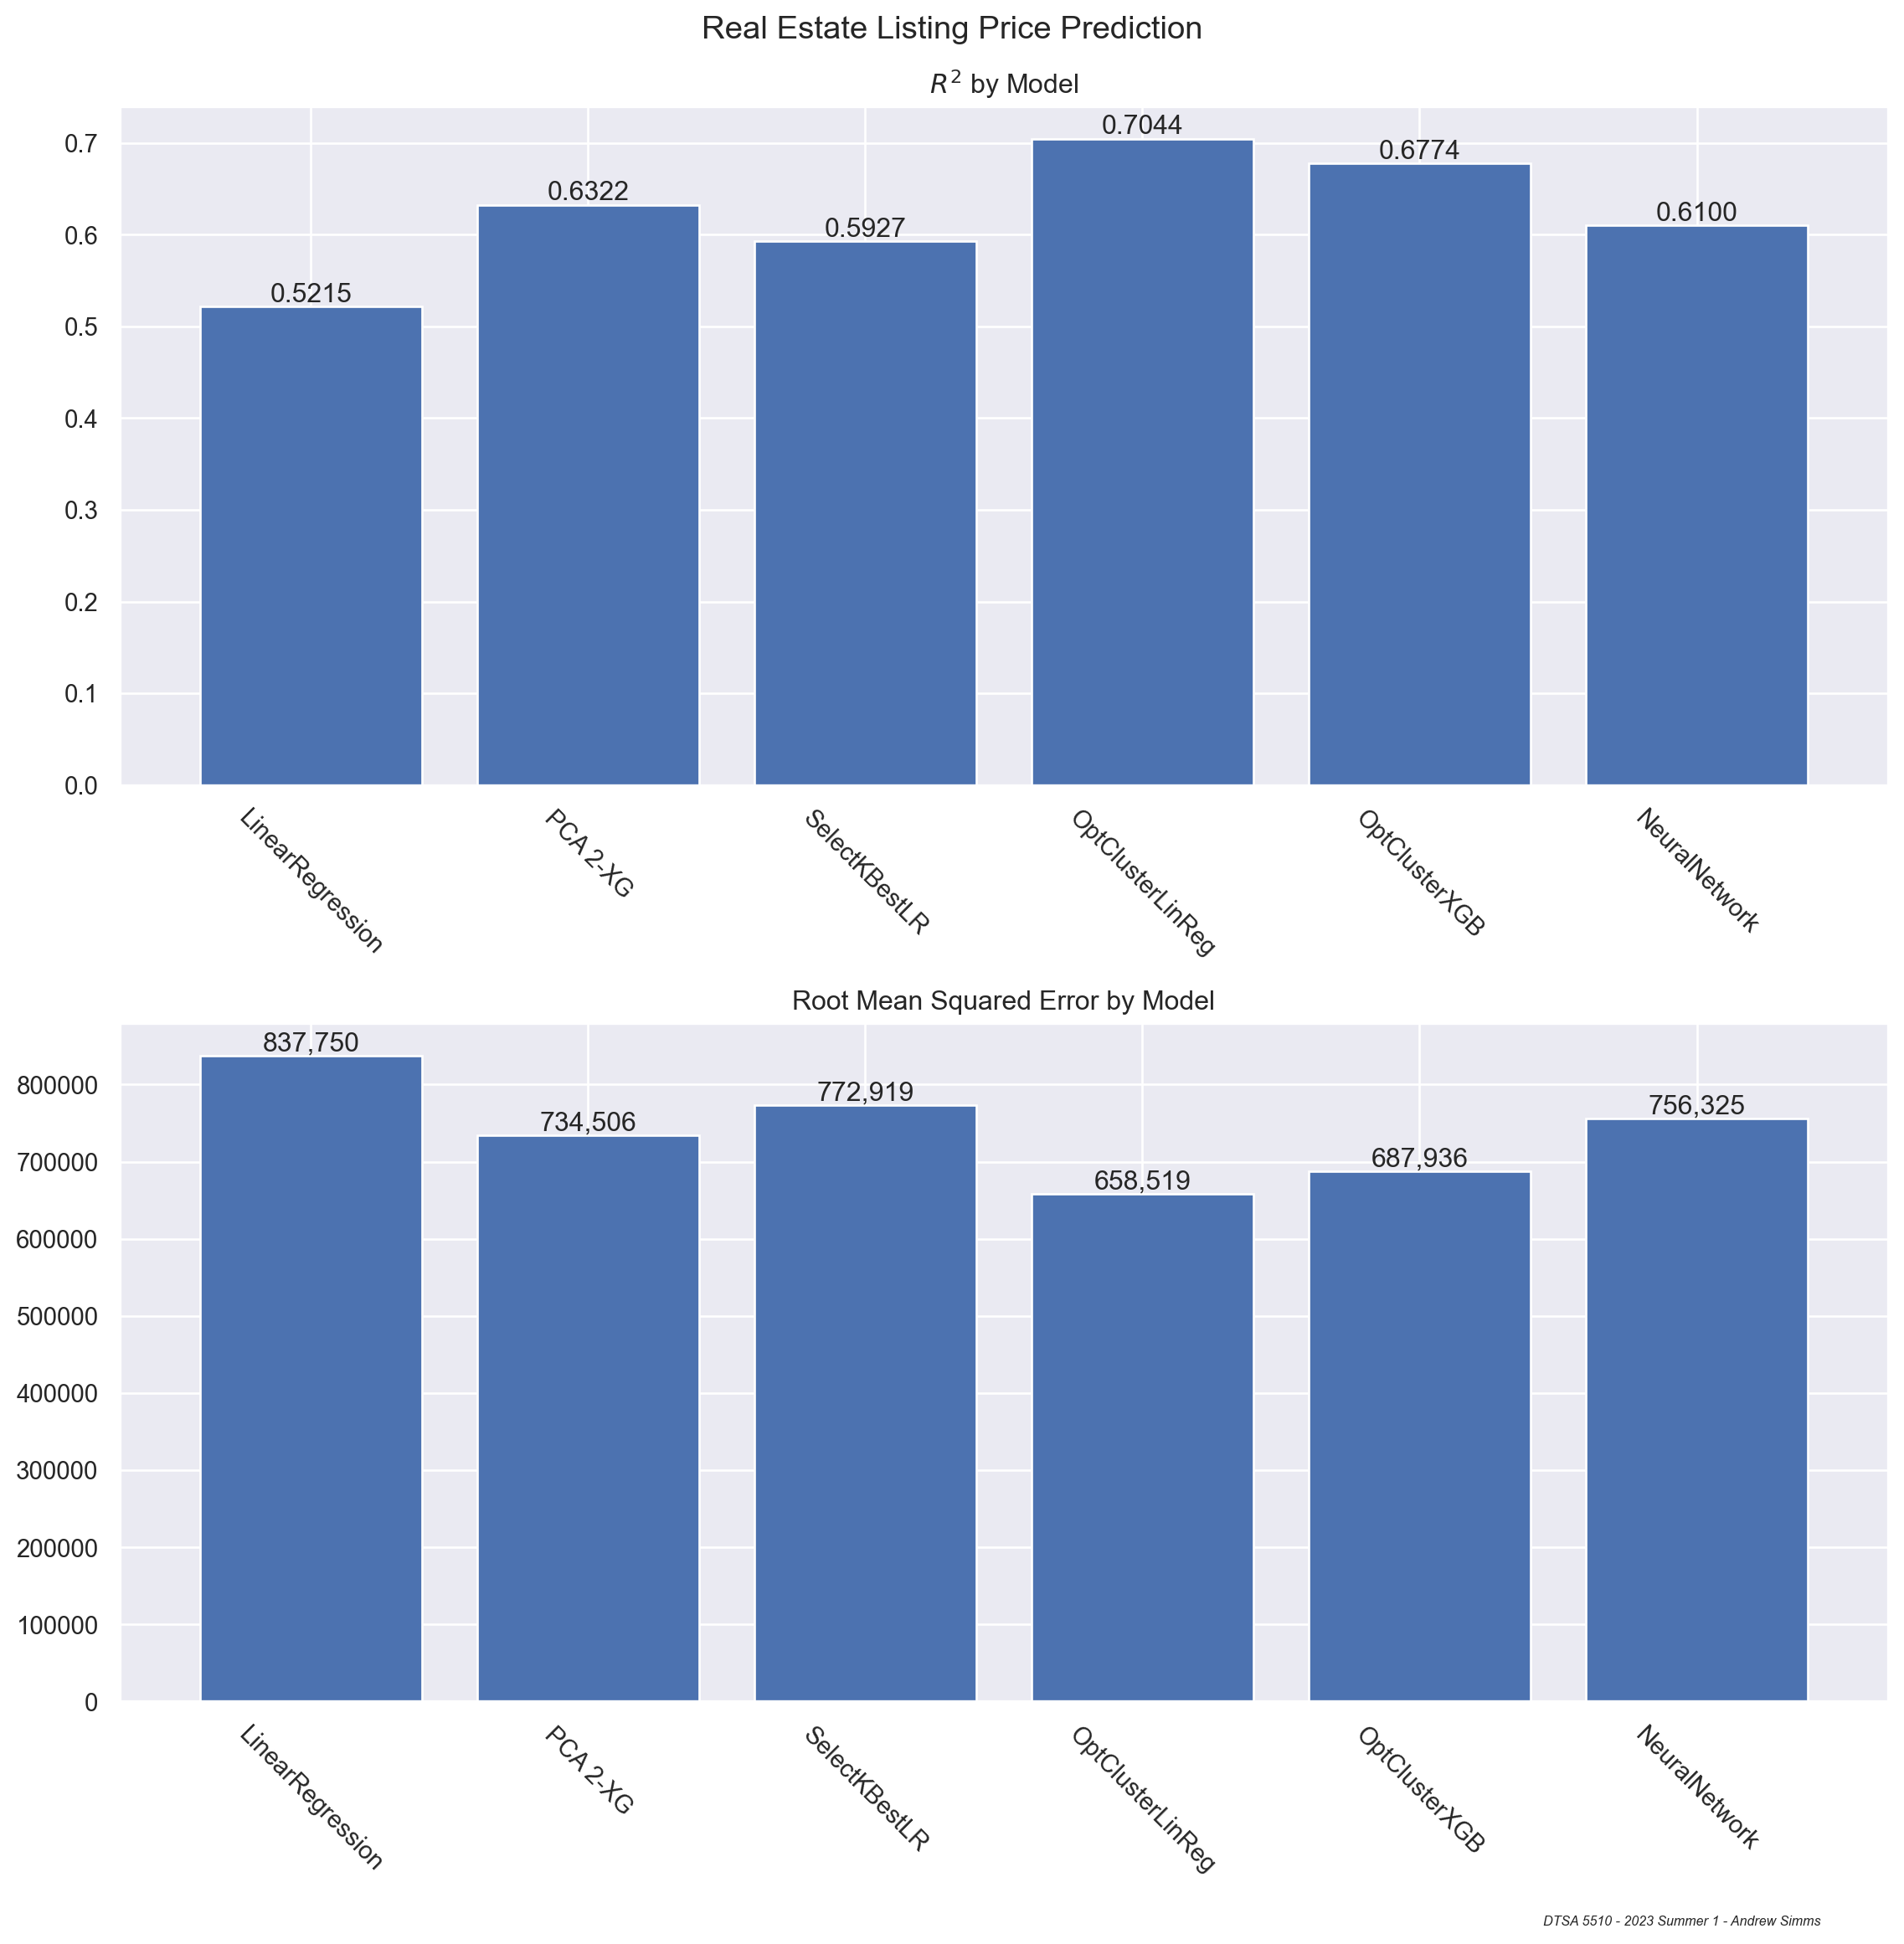

In [67]:
#| label: fig-model-results
#| fig-cap: 'Final Model Accuracy Comparisons, RSME and $R^2$'

plot_model_stats()

:::

## Model Accuracy Analysis {#sec-analysis}

In @fig-model-results we compare the $R^2$ and root mean squared error (RSME) as evaluation metrics
for all models. These are suited for quantification of error in regression algorithms, and are used
as such in this project.  Surprisingly, our clustering regression model (`OptClusterLinReg`)
performed the best when compared to the other models. The next best performing model performing
model was `PCA-2-XG` which performed principal component analysis then ran `XGBRegressor` on the
result. Our neural network and linear regression models performed similarly.

## Execution Time Results

:::{.column-page}


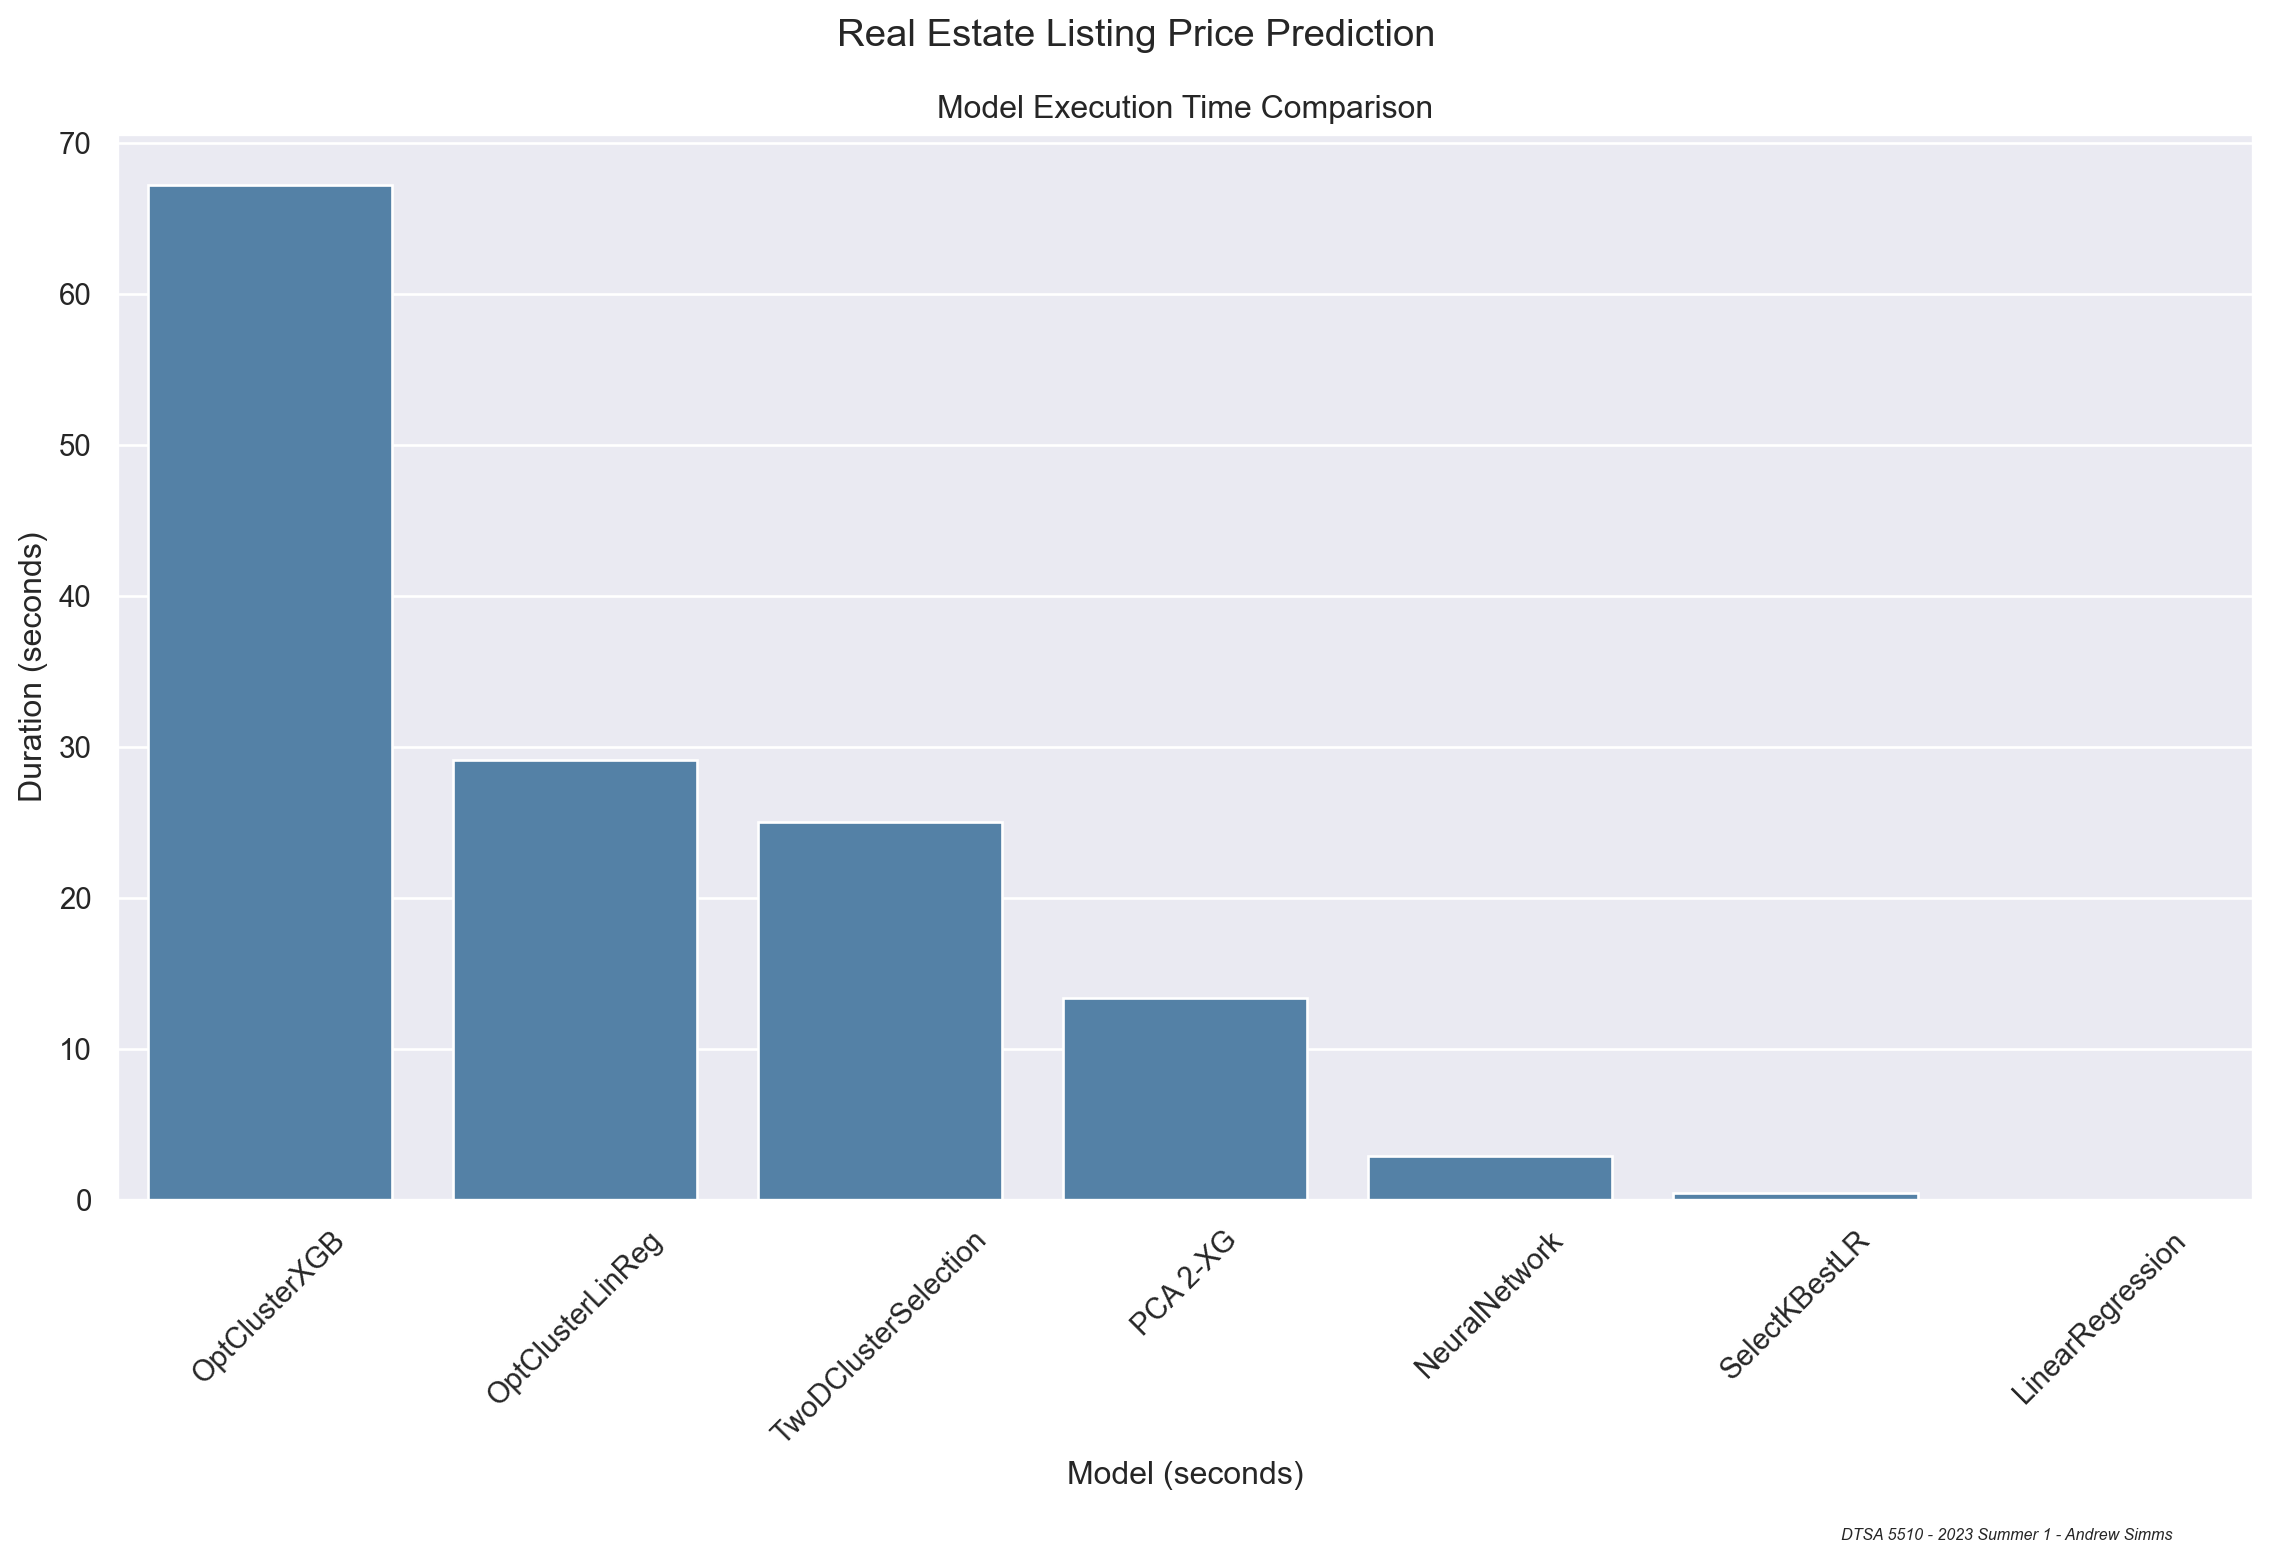

In [68]:
#| label: fig-execution-results
#| fig-cap: 'Final Model Accuracy Comparisons, RSME and $R^2$'
exc_times_df = pd.DataFrame(execution_times).T
exc_times_df = exc_times_df.sort_values("duration", ascending=False)
exc_times_df["model"] = exc_times_df.index

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=exc_times_df, x="model", y="duration", ax=ax, color="steelblue")
plt.title("Model Execution Time Comparison")
plt.ylabel("Duration (seconds)")
plt.xlabel("Model (seconds)")
plt.xticks(rotation=45)
brand_plot()
plt.show()

:::

## Execution Time Analysis

In @fig-execution-results we compare the execution times of all ML models. Here we see that our
clustering regression models `OptClusterXGB`, and `OptClusterLinReg` execute much slower than other
models. While they are more accurate than other models, this accuracy comes at a cost. For these
models one has to consider the execution time cost vs the accuracy. For certain environments it may
be better to sacrifice accuracy for speed.

# Conclusion {#sec-conclusion}

In this project we sought to test and validate methods for using using the output of unsupervised ML
methods as input into supervised ML methods to perform price prediction on real world real estate
listings.

As detailed in @sec-data we started by scraping real estate listings from [Zillow][zillow] and supplementing with data from
[Redfin][redfin]. In total we scraped 718 listings with 161 columns. In @sec-clean the data was
cleaned to remove unnecessary and duplicate features. Categorical data was transformed using one hot
encoding. The data was then split into training and test data sets. @sec-eda visualized feature
importance and took a deeper look at the most import features.

In @sec-model we began with simple linear regression and progressed to using our planned
unsupervised to supervised modeling approach. We used PCA to reduce the dimensionality of the
features, and clustering algorithms to create organized subsets of the data. These subsets were
passed to supervised regression algorithms. For a final comparison we added 3 neural network
implementations.

@sec-results visualizes and analyzes the model accuracy and model execution time results. The best
performing models combine clustering and regression, with the `KMeans` and `LinearRegression`
performing the best. These clustering and regression while accurate are also slow to execute,
especially when compared to the basic linear regression.

Through this project we learned:

* Cleaning techniques for real world real estate listing data
    * One Hot Encoding (OHE) using `pandas.get_dummies`
* Integration of unsupervised and supervised into combined models that predict prices
    * Combining clusters and regression requires careful tracking of the data
* Feature selection with `SelectKBest` provided a relatively large increase in $R^2$ for a small
  increase in execution time:
    * May be ideal solution for environments that can sacrifice accuracy for speed
* Principal Component Analysis offers a simple API for reducing the complexity of features
* Optimization of feature selection becomes increasingly important with the number of inputs:
    * `ClusterRegression` has can iterate over feature columns, cluster columns, and number of
      clusters.
        * Speed optimization required using optimized algorithms for feature selection

Areas of Exploration:

* Tuning hyperparameters of clustering and regression models
* Testing different regression and clustering models
* Speed optimization
* Dataset Tuning
  * Removal of OHE features

Overall, this project provided a solid learning platform to iterate on unsupervised and supervised
machine learning implementations. Throughout this project we were forced to confront the realities
of using machine learning. Some implementations were slow, some were too complex, and some provided
poor accuracy. In the end we were able to follow through on our goal of creating an accurate price
prediction algorithm.


# Python Environment {#sec-code-env}

Below are the versions of python and included libraries used for this project:


In [69]:
#| code-fold: true


import sys
print("Python Version:", sys.version)

# Print module versions: https://stackoverflow.com/a/49199019
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

Python Version: 3.10.10 (main, Feb  8 2023, 05:44:44) [Clang 13.0.0 (clang-1300.0.29.30)]
matplotlib==3.6.2
numpy==1.23.5
pandas==1.5.1
scikit-learn==1.2.0
seaborn==0.12.2
tensorflow==2.12.0
xgboost==1.7.4


[zillow]: https://www.zillow.com
[redfin]: https://www.redfin.com
[scraper.py]: https://github.com/simmsa/dtsa_5510_final/blob/main/scraper.py
[formatter.py]: https://github.com/simmsa/dtsa_5510_final/blob/main/formatter.py
[zip_codes.json]: https://github.com/simmsa/dtsa_5510_final/blob/main/zip_codes.json
[scrapfly]: https://scrapfly.io/blog/how-to-scrape-zillow/#scraping-zillow-properties
[MLS]: https://mls.com
[great_schools]: https://www.redfin.com/definition/great-schools-rating